**You will write your code in this worksheet**

**YOUR CODE WILL BE CHECKED FOR PLAGIARISM**

**Initial Setup**

1. First, you will setup your CoLab environment.

2. Then, you will authenticate a Google Drive client to download the file we will be processing in our Spark job.
Make sure to follow the interactive instructions.

3. Then, you will download the dataset `lastfm.csv` and store it in your drive.
Check the panel in your left to note if the dataset has downloaded correctly under the "Files" tab.

In [ ]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
file_list = drive.ListFile({'q': "'1iUsSO-Fo5D5c0YX9_6RgA1cy4IK_Da4-' in parents"}).GetList()
for f in file_list:
  print('title: %s, id: %s' % (f['title'], f['id']))

In [ ]:
id='1q7iH1KpSPEtd35NAOqvA35mikPhracDY'
downloaded = drive.CreateFile({'id': id})
downloaded.GetContentFile('lastfm.csv')

***Check whether your dataset was downloaded and stored correctly***

## **From this point onwards, you are supposed to do the coding yourself. Refer the Exercise Sheet to carry out your analysis**

In [ ]:
# Loading all the relevant Panda, Spark libraries which includes the Apriori and FPGrowth libraries as well

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pyspark
from pyspark.sql import *
from pyspark.sql.functions import *
from pyspark import SparkContext, SparkConf
from pyspark.ml.fpm import FPGrowth
import sys
!{sys.executable} -m pip install pandas-profiling
import statsmodels.formula.api as sm
import missingno as msno

from plotly.offline import init_notebook_mode, iplot_mpl, download_plotlyjs, plot, iplot
import plotly.figure_factory as ff
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')
init_notebook_mode(connected=True)
import statsmodels.formula.api as sm
import missingno as msno
from sklearn.preprocessing import LabelEncoder
from statsmodels.compat import lzip
import statsmodels.api as sm
from sklearn.preprocessing import scale
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples

import seaborn as sns
sns.set_style('white')
import scipy
import os
import zipfile
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
from mlxtend.preprocessing import TransactionEncoder
from sklearn.model_selection import train_test_split


!pip install -q findspark
import findspark

findspark.init()
from pyspark.sql import SparkSession

from pyspark.sql.functions import col
from pyspark.sql.types import StringType,BooleanType,DateType,IntegerType

from pyspark.sql import *
from pyspark.sql.types import *
from pyspark.sql.functions import *
from datetime import date, timedelta, datetime
import time

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Creating Spark entry point
spark_session = SparkSession.builder.master('local[*]').getOrCreate()

#**Data Exploration and Pre-processing**

In [ ]:
## Reading the file through PySpark, printing the dataset, and showing the first few observations
lastfm_data = spark_session.read.csv('/content/lastfm.csv', header=True, inferSchema=True)

# Caching the dataset
lastfm_data.cache()

#lastfm_data = spark_session.read.options(header='true',).csv('/content/lastfm.csv')
lastfm_data.printSchema()
lastfm_data.show(truncate=False)
lastfm_data.take(50)

root
 |-- user: integer (nullable = true)
 |-- artist: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- country: string (nullable = true)

+----+-----------------------+---+-------------+
|user|artist                 |sex|country      |
+----+-----------------------+---+-------------+
|1   |red hot chili peppers  |f  |Germany      |
|1   |the black dahlia murder|f  |Germany      |
|1   |goldfrapp              |f  |Germany      |
|1   |dropkick murphys       |f  |Germany      |
|1   |le tigre               |f  |Germany      |
|1   |schandmaul             |f  |Germany      |
|1   |edguy                  |f  |Germany      |
|1   |jack johnson           |f  |Germany      |
|1   |eluveitie              |f  |Germany      |
|1   |the killers            |f  |Germany      |
|1   |judas priest           |f  |Germany      |
|1   |rob zombie             |f  |Germany      |
|1   |john mayer             |f  |Germany      |
|1   |the who                |f  |Germany      |
|1   |guano 

[Row(user=1, artist='red hot chili peppers', sex='f', country='Germany'),
 Row(user=1, artist='the black dahlia murder', sex='f', country='Germany'),
 Row(user=1, artist='goldfrapp', sex='f', country='Germany'),
 Row(user=1, artist='dropkick murphys', sex='f', country='Germany'),
 Row(user=1, artist='le tigre', sex='f', country='Germany'),
 Row(user=1, artist='schandmaul', sex='f', country='Germany'),
 Row(user=1, artist='edguy', sex='f', country='Germany'),
 Row(user=1, artist='jack johnson', sex='f', country='Germany'),
 Row(user=1, artist='eluveitie', sex='f', country='Germany'),
 Row(user=1, artist='the killers', sex='f', country='Germany'),
 Row(user=1, artist='judas priest', sex='f', country='Germany'),
 Row(user=1, artist='rob zombie', sex='f', country='Germany'),
 Row(user=1, artist='john mayer', sex='f', country='Germany'),
 Row(user=1, artist='the who', sex='f', country='Germany'),
 Row(user=1, artist='guano apes', sex='f', country='Germany'),
 Row(user=1, artist='the rolling

In [ ]:
#Making the user column as Integer
lastfm_data = lastfm_data.withColumn("user", lastfm_data["user"].cast(IntegerType()))
lastfm_data.printSchema()

root
 |-- user: integer (nullable = true)
 |-- artist: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- country: string (nullable = true)



In [ ]:
print('Columns overview')
pd.DataFrame(lastfm_data.dtypes, columns = ['Column Name', 'Data type'])
print("The shape of the lastfm data is " + str(lastfm_data.count()) + " rows and "+ str(len(lastfm_data.columns))+ " columns")

Columns overview
The shape of the lastfm data is 289955 rows and 4 columns


In [ ]:
# Counts the number of distinct rows in dataframe
lastfm_data.distinct().count()

289953

In [ ]:
# There are 2 duplicate rows as the distinct count is 289953 and the overall observations are 289955. Let us check the duplicate rows

lastfm_data.groupby(['user', 'artist', 'sex', 'country']).count().where('count > 1').sort('count', ascending=False).show()

+----+-----------+---+--------------+-----+
|user|     artist|sex|       country|count|
+----+-----------+---+--------------+-----+
|9753|james brown|  m|       Germany|    2|
|6980|     m.i.a.|  f|United Kingdom|    2|
+----+-----------+---+--------------+-----+



In [ ]:
# As mentioned above there 2 duplicate rows. Now we can remove these duplicate rows. A new dataframe is created lastfm_data_nodup
lastfm_data_nodup = lastfm_data.dropDuplicates()
print("Distinct count: "+str(lastfm_data_nodup.count()))
lastfm_data_nodup.show(truncate=False)

Distinct count: 289953
+----+------------------------+---+------------------+
|user|artist                  |sex|country           |
+----+------------------------+---+------------------+
|19  |le tigre                |f  |Sweden            |
|28  |rage against the machine|m  |Sweden            |
|47  |john coltrane           |m  |Italy             |
|64  |trentemøller            |m  |Poland            |
|74  |sirenia                 |m  |Spain             |
|97  |johnny cash             |m  |United States     |
|124 |anathema                |m  |Brazil            |
|129 |bloc party              |f  |Poland            |
|136 |madonna                 |f  |Brazil            |
|138 |the offspring           |m  |Sweden            |
|173 |iron maiden             |m  |Australia         |
|191 |otis redding            |f  |United States     |
|202 |sarah mclachlan         |f  |Ghana             |
|213 |doves                   |f  |United States     |
|224 |hot chip                |m  |United 

In [ ]:
# Returns columns of dataframe
lastfm_data_nodup.columns

['user', 'artist', 'sex', 'country']

In [ ]:
# Checking if there are any NULL values in the columns
lastfm_data_nodup.filter(lastfm_data_nodup.user.isNull()).show()
lastfm_data_nodup.filter(lastfm_data_nodup.artist.isNull()).show()
lastfm_data_nodup.filter(lastfm_data_nodup.sex.isNull()).show()
lastfm_data_nodup.filter(lastfm_data_nodup.country.isNull()).show()

# There are no NULL or missing values in the dataset

+----+------+---+-------+
|user|artist|sex|country|
+----+------+---+-------+
+----+------+---+-------+

+----+------+---+-------+
|user|artist|sex|country|
+----+------+---+-------+
+----+------+---+-------+

+----+------+---+-------+
|user|artist|sex|country|
+----+------+---+-------+
+----+------+---+-------+

+----+------+---+-------+
|user|artist|sex|country|
+----+------+---+-------+
+----+------+---+-------+



In [ ]:
# Computes summary statistics. 
lastfm_data_nodup.describe().show()

+-------+-----------------+--------------------+------+-----------+
|summary|             user|              artist|   sex|    country|
+-------+-----------------+--------------------+------+-----------+
|  count|           289953|              289953|289953|     289953|
|   mean|9852.470696975028|  178.03614457831324|  null|       null|
| stddev|5692.372170724107|  133.76780367937874|  null|       null|
|    min|                1|...and you will k...|     f|Afghanistan|
|    max|            19718|          Édith piaf|     m|   Zimbabwe|
+-------+-----------------+--------------------+------+-----------+



In [ ]:
# To see the user which have the highest number of user records
lastfm_data_nodup.groupBy('user').count().orderBy('count', ascending=False).show(10)


print(type(lastfm_data_nodup))
# We can see the top 3 users/listeners are user ids 17681, 15057 and 1208 

+-----+-----+
| user|count|
+-----+-----+
|17681|   76|
|15057|   63|
| 1208|   55|
|19558|   55|
|13424|   54|
| 3288|   52|
| 5332|   52|
| 5765|   52|
|16852|   51|
|15003|   51|
+-----+-----+
only showing top 10 rows

<class 'pyspark.sql.dataframe.DataFrame'>


In [ ]:
# Using groupby on Sex column
lastfm_data_nodup.groupBy("sex").count().show(truncate=False)

# The dataframe shows the the number of male users are more than the female users

+---+------+
|sex|count |
+---+------+
|m  |211822|
|f  |78131 |
+---+------+



In [ ]:
# Using groupby on Country column
lastfm_data_nodup.groupBy("country").count().orderBy('count', ascending=False).show(truncate=False)

# The dataframe shows United States, United Kingdom amd Germany are the top 3 countries where the users/listeners are from

+------------------+-----+
|country           |count|
+------------------+-----+
|United States     |59558|
|United Kingdom    |27637|
|Germany           |24250|
|Poland            |17111|
|Sweden            |12379|
|Brazil            |11922|
|Russian Federation|11676|
|Finland           |10157|
|Netherlands       |9673 |
|Spain             |9322 |
|Canada            |6928 |
|Australia         |6407 |
|France            |5962 |
|Italy             |5717 |
|Turkey            |4762 |
|Norway            |4641 |
|Mexico            |3803 |
|Czech Republic    |3752 |
|Belgium           |3331 |
|Portugal          |2882 |
+------------------+-----+
only showing top 20 rows



In [ ]:
# Check the unique artist values based on the users
lastfm_data_nodup.groupBy("artist").count().orderBy('count', ascending=False).show(truncate=False)

# The artists radiohead, the beatles and coldplay are the most listened

+---------------------+-----+
|artist               |count|
+---------------------+-----+
|radiohead            |2704 |
|the beatles          |2668 |
|coldplay             |2378 |
|red hot chili peppers|1786 |
|muse                 |1711 |
|metallica            |1670 |
|pink floyd           |1574 |
|linkin park          |1473 |
|nirvana              |1473 |
|the killers          |1473 |
|system of a down     |1365 |
|death cab for cutie  |1220 |
|led zeppelin         |1188 |
|queen                |1166 |
|placebo              |1162 |
|daft punk            |1140 |
|the cure             |1139 |
|arctic monkeys       |1132 |
|depeche mode         |1132 |
|david bowie          |1105 |
+---------------------+-----+
only showing top 20 rows



In [ ]:
# Upon analyzing the dataset we see that in the artist column there are few artist names as "unknown". We will filter those values from the dataset
lastfm_data_nodup.filter(lastfm_data_nodup.artist == "[unknown]").show(truncate=False)

# Checking how many rows are there for the [unknown] users. There are 553 rows with unknown artists. It would be better to drop these unkown are there are not 1% of the overall dataset and would not impact our analysis
lastfm_data_nodup.groupby(['artist']).count().where(lastfm_data_nodup.artist == "[unknown]").sort('count', ascending=False).show()

+-----+---------+---+-------------------------------------+
|user |artist   |sex|country                              |
+-----+---------+---+-------------------------------------+
|4677 |[unknown]|f  |Spain                                |
|1043 |[unknown]|f  |Poland                               |
|3951 |[unknown]|m  |Poland                               |
|8600 |[unknown]|f  |Ukraine                              |
|13585|[unknown]|m  |Finland                              |
|13924|[unknown]|m  |Mexico                               |
|3156 |[unknown]|m  |Germany                              |
|4069 |[unknown]|m  |Poland                               |
|1638 |[unknown]|m  |United Kingdom                       |
|1865 |[unknown]|m  |Ukraine                              |
|5622 |[unknown]|m  |United States                        |
|5719 |[unknown]|m  |Netherlands                          |
|12966|[unknown]|f  |Spain                                |
|12792|[unknown]|m  |Argentina          

In [ ]:
# Filtering out the unknown artists

lastfm_data_nounknown = lastfm_data_nodup.filter(lastfm_data_nodup.artist != "[unknown]")
  
print("Distinct count: "+str(lastfm_data_nodup.count()))
print("Distinct count: "+str(lastfm_data_nounknown.count()))

# From the above we can see 553 rows are not present in the lastfm_data_nounknown

print(type(lastfm_data_nounknown))

Distinct count: 289953
Distinct count: 289400
<class 'pyspark.sql.dataframe.DataFrame'>


In [ ]:
# Using groupby on Country column after removing the unknown artists
lastfm_data_nounknown.groupBy("country").count().orderBy('count', ascending=False).show(truncate=False)

+------------------+-----+
|country           |count|
+------------------+-----+
|United States     |59514|
|United Kingdom    |27612|
|Germany           |24168|
|Poland            |17049|
|Sweden            |12362|
|Brazil            |11899|
|Russian Federation|11644|
|Finland           |10141|
|Netherlands       |9660 |
|Spain             |9288 |
|Canada            |6925 |
|Australia         |6403 |
|France            |5951 |
|Italy             |5709 |
|Turkey            |4735 |
|Norway            |4634 |
|Mexico            |3792 |
|Czech Republic    |3739 |
|Belgium           |3328 |
|Portugal          |2879 |
+------------------+-----+
only showing top 20 rows



In [ ]:
# Let us analyze the top 3 artists based on the user
df1 = lastfm_data_nounknown.select('artist', 'user').filter(lastfm_data_nounknown.artist == 'radiohead').groupby('artist', 'user').agg(count('*').alias('count')).orderBy(desc('count')).limit(10)

# Check dataframe
df1.show()

df2 = lastfm_data_nounknown.select('artist', 'user').filter(lastfm_data_nounknown.artist == 'the beatles').groupby('artist', 'user').agg(count('*').alias('count')).orderBy(desc('count')).limit(10)

# Check dataframe
df2.show()

df3 = lastfm_data_nounknown.select('artist', 'user').filter(lastfm_data_nounknown.artist == 'coldplay').groupby('artist', 'user').agg(count('*').alias('count')).orderBy(desc('count')).limit(10)

# Check dataframe
df3.show()

+---------+-----+-----+
|   artist| user|count|
+---------+-----+-----+
|radiohead|13144|    1|
|radiohead|  670|    1|
|radiohead| 4690|    1|
|radiohead| 9322|    1|
|radiohead|12776|    1|
|radiohead|12786|    1|
|radiohead|  749|    1|
|radiohead|  413|    1|
|radiohead| 3320|    1|
|radiohead|14673|    1|
+---------+-----+-----+

+-----------+-----+-----+
|     artist| user|count|
+-----------+-----+-----+
|the beatles| 1174|    1|
|the beatles|10929|    1|
|the beatles|11365|    1|
|the beatles| 5180|    1|
|the beatles|14631|    1|
|the beatles| 4915|    1|
|the beatles|14157|    1|
|the beatles|10351|    1|
|the beatles| 4095|    1|
|the beatles| 7490|    1|
+-----------+-----+-----+

+--------+-----+-----+
|  artist| user|count|
+--------+-----+-----+
|coldplay|14306|    1|
|coldplay|11770|    1|
|coldplay|13240|    1|
|coldplay| 8328|    1|
|coldplay|  268|    1|
|coldplay| 7448|    1|
|coldplay|  249|    1|
|coldplay|17878|    1|
|coldplay|18276|    1|
|coldplay|17192|    1|

In [ ]:
# Let us analyze the top 3 artists further more based on sex
df1 = lastfm_data_nounknown.select('artist', 'sex').filter(lastfm_data_nounknown.artist == 'radiohead').groupby('artist', 'sex').agg(count('*').alias('count')).orderBy(desc('count'))

# Check dataframe
df1.show()

df2 = lastfm_data_nounknown.select('artist', 'sex').filter(lastfm_data_nounknown.artist == 'the beatles').groupby('artist', 'sex').agg(count('*').alias('count')).orderBy(desc('count'))

# Check dataframe
df2.show()

df3 = lastfm_data_nounknown.select('artist', 'sex').filter(lastfm_data_nounknown.artist == 'coldplay').groupby('artist', 'sex').agg(count('*').alias('count')).orderBy(desc('count'))

# Check dataframe
df3.show()

# We can see that majority of the listeners of top 3 artists are males

+---------+---+-----+
|   artist|sex|count|
+---------+---+-----+
|radiohead|  m| 1982|
|radiohead|  f|  722|
+---------+---+-----+

+-----------+---+-----+
|     artist|sex|count|
+-----------+---+-----+
|the beatles|  m| 1908|
|the beatles|  f|  760|
+-----------+---+-----+

+--------+---+-----+
|  artist|sex|count|
+--------+---+-----+
|coldplay|  m| 1580|
|coldplay|  f|  798|
+--------+---+-----+



In [ ]:
# Let us analyze based on sex who are the listeners are and what they majorly listen to
df1 = lastfm_data_nounknown.select('sex', 'artist').filter(lastfm_data_nounknown.sex == 'm').groupby('sex', 'artist').agg(count('*').alias('count')).orderBy(desc('count')).limit(10)

# Check dataframe
df1.show()

df2 = lastfm_data_nounknown.select('sex', 'artist').filter(lastfm_data_nounknown.sex == 'f').groupby('sex', 'artist').agg(count('*').alias('count')).orderBy(desc('count')).limit(10)

# Check dataframe
df2.show()

# We can see that majority of the male and female listeners listen to radiohead, the beatles and coldplay.

+---+--------------------+-----+
|sex|              artist|count|
+---+--------------------+-----+
|  m|           radiohead| 1982|
|  m|         the beatles| 1908|
|  m|            coldplay| 1580|
|  m|           metallica| 1424|
|  m|red hot chili pep...| 1344|
|  m|          pink floyd| 1272|
|  m|                muse| 1150|
|  m|             nirvana| 1123|
|  m|    system of a down| 1092|
|  m|         linkin park| 1090|
+---+--------------------+-----+

+---+--------------------+-----+
|sex|              artist|count|
+---+--------------------+-----+
|  f|            coldplay|  798|
|  f|         the beatles|  760|
|  f|           radiohead|  722|
|  f|                muse|  561|
|  f| death cab for cutie|  484|
|  f|         the killers|  483|
|  f|             placebo|  470|
|  f|red hot chili pep...|  442|
|  f|       amy winehouse|  410|
|  f|            the cure|  391|
+---+--------------------+-----+



In [ ]:
# Let us analyze the top 3 artists further more based on country
df1 = lastfm_data_nounknown.select('artist', 'country').filter(lastfm_data_nounknown.artist == 'radiohead').groupby('artist', 'country').agg(count('*').alias('count')).orderBy(desc('count')).limit(10)

# Check dataframe
df1.show()

df2 = lastfm_data_nounknown.select('artist', 'country').filter(lastfm_data_nounknown.artist == 'the beatles').groupby('artist', 'country').agg(count('*').alias('count')).orderBy(desc('count')).limit(10)

# Check dataframe
df2.show()

df3 = lastfm_data_nounknown.select('artist', 'country').filter(lastfm_data_nounknown.artist == 'coldplay').groupby('artist', 'country').agg(count('*').alias('count')).orderBy(desc('count')).limit(10)

# Check dataframe
df3.show()

# We can see that majority of the listeners of radiohead are from US, UK and Germany, for the beatles it US, UK and Brazil, for coldplay the listeners are from US, Germany, UK

+---------+------------------+-----+
|   artist|           country|count|
+---------+------------------+-----+
|radiohead|     United States|  671|
|radiohead|    United Kingdom|  291|
|radiohead|           Germany|  115|
|radiohead|            Brazil|  109|
|radiohead|Russian Federation|  101|
|radiohead|            Poland|   98|
|radiohead|             Spain|   89|
|radiohead|       Netherlands|   88|
|radiohead|            France|   88|
|radiohead|             Italy|   86|
+---------+------------------+-----+

+-----------+------------------+-----+
|     artist|           country|count|
+-----------+------------------+-----+
|the beatles|     United States|  786|
|the beatles|    United Kingdom|  270|
|the beatles|            Brazil|  161|
|the beatles|           Germany|  130|
|the beatles|Russian Federation|  109|
|the beatles|            Poland|   90|
|the beatles|            Sweden|   88|
|the beatles|       Netherlands|   83|
|the beatles|            Canada|   81|
|the beatles|

In [ ]:
# Let us analyze the top 3 countries further more based on artists
df1 = lastfm_data_nounknown.select('country', 'artist').filter(lastfm_data_nounknown.country == 'United States').groupby('country', 'artist').agg(count('*').alias('count')).orderBy(desc('count')).limit(10)

# Check dataframe
df1.show()

df2 = lastfm_data_nounknown.select('country', 'artist').filter(lastfm_data_nounknown.country == 'United Kingdom').groupby('country', 'artist').agg(count('*').alias('count')).orderBy(desc('count')).limit(10)

# Check dataframe
df2.show()

df3 = lastfm_data_nounknown.select('country', 'artist').filter(lastfm_data_nounknown.country == 'Germany').groupby('country', 'artist').agg(count('*').alias('count')).orderBy(desc('count')).limit(10)

# Check dataframe
df3.show()

# We can see that majority of the listeners in the United States are the beatles, radiohead and death cab for cutie
# We can see that majority of the listeners in the United Kingdom are the radiohead, the beatles and muse
# We can see that majority of the listeners in Germany are the die Arzte, linkin park and coldplay

+-------------+-------------------+-----+
|      country|             artist|count|
+-------------+-------------------+-----+
|United States|        the beatles|  786|
|United States|          radiohead|  671|
|United States|death cab for cutie|  513|
|United States|           coldplay|  447|
|United States|       modest mouse|  414|
|United States|          the shins|  363|
|United States|         kanye west|  340|
|United States|     sufjan stevens|  330|
|United States|         pink floyd|  322|
|United States|               beck|  319|
+-------------+-------------------+-----+

+--------------+--------------+-----+
|       country|        artist|count|
+--------------+--------------+-----+
|United Kingdom|     radiohead|  291|
|United Kingdom|   the beatles|  270|
|United Kingdom|          muse|  209|
|United Kingdom|   david bowie|  193|
|United Kingdom| kings of leon|  188|
|United Kingdom|      coldplay|  188|
|United Kingdom|    bloc party|  171|
|United Kingdom|   the killers|

In [ ]:
# Let us analyze the top 3 countries based on number of listeners further more based on male listeners
df1 = lastfm_data_nounknown.select('country', 'sex','artist').filter((lastfm_data_nounknown.country == 'United States') & (lastfm_data_nounknown.sex  == "m")).groupby('country', 'sex','artist').agg(count('*').alias('count')).orderBy(desc('count')).limit(10)

# Check dataframe
df1.show()


df2 = lastfm_data_nounknown.select('country', 'sex','artist').filter((lastfm_data_nounknown.country == 'United Kingdom') & (lastfm_data_nounknown.sex  == "m")).groupby('country', 'sex','artist').agg(count('*').alias('count')).orderBy(desc('count')).limit(10)

# Check dataframe
df2.show()


df3 = lastfm_data_nounknown.select('country', 'sex','artist').filter((lastfm_data_nounknown.country == 'Germany') & (lastfm_data_nounknown.sex  == "m")).groupby('country', 'sex','artist').agg(count('*').alias('count')).orderBy(desc('count')).limit(10)

# Check dataframe
df3.show()

+-------------+---+-------------------+-----+
|      country|sex|             artist|count|
+-------------+---+-------------------+-----+
|United States|  m|        the beatles|  518|
|United States|  m|          radiohead|  466|
|United States|  m|death cab for cutie|  289|
|United States|  m|       modest mouse|  278|
|United States|  m|         pink floyd|  258|
|United States|  m|           coldplay|  249|
|United States|  m|       led zeppelin|  241|
|United States|  m|         kanye west|  232|
|United States|  m|          bob dylan|  213|
|United States|  m|               beck|  213|
+-------------+---+-------------------+-----+

+--------------+---+--------------------+-----+
|       country|sex|              artist|count|
+--------------+---+--------------------+-----+
|United Kingdom|  m|           radiohead|  248|
|United Kingdom|  m|         the beatles|  228|
|United Kingdom|  m|                muse|  168|
|United Kingdom|  m|            coldplay|  154|
|United Kingdom|  m

In [ ]:
# Let us analyze the top 3 countries based on number of listeners further more based on female listeners
df1 = lastfm_data_nounknown.select('country', 'sex','artist').filter((lastfm_data_nounknown.country == 'United States') & (lastfm_data_nounknown.sex  == "f")).groupby('country', 'sex','artist').agg(count('*').alias('count')).orderBy(desc('count')).limit(10)

# Check dataframe
df1.show()


df2 = lastfm_data_nounknown.select('country', 'sex','artist').filter((lastfm_data_nounknown.country == 'United Kingdom') & (lastfm_data_nounknown.sex  == "f")).groupby('country', 'sex','artist').agg(count('*').alias('count')).orderBy(desc('count')).limit(10)

# Check dataframe
df2.show()


df3 = lastfm_data_nounknown.select('country', 'sex','artist').filter((lastfm_data_nounknown.country == 'Germany') & (lastfm_data_nounknown.sex  == "f")).groupby('country', 'sex','artist').agg(count('*').alias('count')).orderBy(desc('count')).limit(10)

# Check dataframe
df3.show()

+-------------+---+-------------------+-----+
|      country|sex|             artist|count|
+-------------+---+-------------------+-----+
|United States|  f|        the beatles|  268|
|United States|  f|death cab for cutie|  224|
|United States|  f|          radiohead|  205|
|United States|  f|           coldplay|  198|
|United States|  f|          the shins|  165|
|United States|  f|       modest mouse|  136|
|United States|  f|     sufjan stevens|  132|
|United States|  f|     regina spektor|  112|
|United States|  f|              feist|  109|
|United States|  f|        bright eyes|  109|
+-------------+---+-------------------+-----+

+--------------+---+--------------+-----+
|       country|sex|        artist|count|
+--------------+---+--------------+-----+
|United Kingdom|  f|     radiohead|   43|
|United Kingdom|  f|   the beatles|   42|
|United Kingdom|  f|   the killers|   41|
|United Kingdom|  f|          muse|   41|
|United Kingdom|  f|   david bowie|   40|
|United Kingdom|  f

In [ ]:
#Top 3 users which country they are from, their sex and count of artists they have listened to
df1 = lastfm_data_nounknown.select('user', 'country', 'sex').filter(lastfm_data_nounknown.user == 17681) .groupby('user','country', 'sex').agg(count('*').alias('count')).orderBy(desc('count')).limit(10)


# Check dataframe
df1.show()

df2 = lastfm_data_nounknown.select('user','country', 'sex').filter(lastfm_data_nounknown.user == 15057) .groupby('user','country', 'sex').agg(count('*').alias('count')).orderBy(desc('count')).limit(10)

# Check dataframe
df2.show()

df3 = lastfm_data_nounknown.select('user', 'country', 'sex').filter(lastfm_data_nounknown.user == 1208) .groupby('user','country', 'sex').agg(count('*').alias('count')).orderBy(desc('count')).limit(10)

# Check dataframe
df3.show()

# We can see here that the top 3 listeners are from New Zealand, United States and Mexico, one of them is female and other 2 are males

+-----+-----------+---+-----+
| user|    country|sex|count|
+-----+-----------+---+-----+
|17681|New Zealand|  f|   76|
+-----+-----------+---+-----+

+-----+-------------+---+-----+
| user|      country|sex|count|
+-----+-------------+---+-----+
|15057|United States|  m|   63|
+-----+-------------+---+-----+

+----+-------+---+-----+
|user|country|sex|count|
+----+-------+---+-----+
|1208| Mexico|  m|   55|
+----+-------+---+-----+



In [ ]:
# Converting the pyspark sql dataframe to Pandas dataframe
lastfm_data_nounknown_pd = lastfm_data_nounknown.toPandas()
print(lastfm_data_nounknown_pd)
print(type(lastfm_data_nounknown_pd))

         user                    artist sex        country
0          19                  le tigre   f         Sweden
1          28  rage against the machine   m         Sweden
2          47             john coltrane   m          Italy
3          64              trentemøller   m         Poland
4          74                   sirenia   m          Spain
...       ...                       ...  ..            ...
289395  19675             enter shikari   m        Hungary
289396  19676                 bob dylan   f  United States
289397  19677              jack johnson   m      Australia
289398  19683              cypress hill   m         Poland
289399  19697               fatboy slim   m        Belgium

[289400 rows x 4 columns]
<class 'pandas.core.frame.DataFrame'>


In [ ]:
lastfm_data_nounknown_pd.head()

user                    artist sex country
0    19                  le tigre   f  Sweden
1    28  rage against the machine   m  Sweden
2    47             john coltrane   m   Italy
3    64              trentemøller   m  Poland
4    74                   sirenia   m   Spain

In [ ]:
print("User unique: ",len(lastfm_data_nounknown_pd.user.unique()))
print("Artist unique: ",len(lastfm_data_nounknown_pd.artist.unique()))
print("Country unique: ",len(lastfm_data_nounknown_pd.country.unique()))

User unique:  14995
Artist unique:  1003
Country unique:  159


In [ ]:
## Check the information about the Lastfm dataset
lastfm_data_nounknown_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 289400 entries, 0 to 289399
Data columns (total 4 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   user     289400 non-null  int32 
 1   artist   289400 non-null  object
 2   sex      289400 non-null  object
 3   country  289400 non-null  object
dtypes: int32(1), object(3)
memory usage: 7.7+ MB


In [ ]:
## Checking for NULL values. There are no NULL values found
lastfm_data_nounknown_pd.isnull().sum()

user       0
artist     0
sex        0
country    0
dtype: int64

<class 'pandas.core.frame.DataFrame'>
<class 'pyspark.sql.dataframe.DataFrame'>


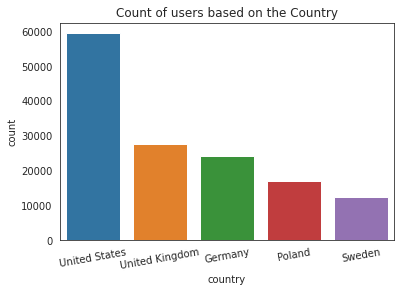

In [ ]:
# Check the count of users based on Country
lastfm_country = lastfm_data_nounknown.groupby(['country']).count().sort('count',ascending=False).toPandas().head(5)

print(type(lastfm_country))
print(type(lastfm_data_nounknown))


#lastfm_country.reset_index(inplace=True)
#lastfm_country = lastfm_country[['country','count']]
#lastfm_country = lastfm_country.rename(columns={'count': 'Count of users based on the Country'})
#lastfm_country

## Some visualization show the distribution of Users based on the Country
#plt.figure(figsize=(50, 40))
#lastfm_country.head(20).plot(kind="bar", x="country", y="Count of users based on the Country")
#plt.show()

sns.barplot(x='country', y='count', data=lastfm_country)
plt.xticks(rotation=10)
plt.title('Count of users based on the Country');

## Now let us save the figure
plt.savefig('Lastfm_Country.png')

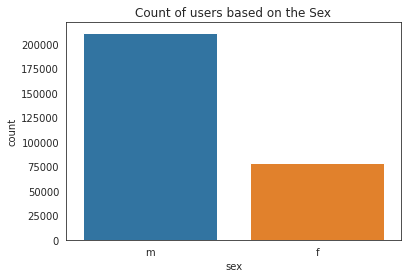

In [ ]:
# Check the count of users based on sex
#lastfm_sex = lastfm_data_nounknown_pd.groupby(['sex']).count().sort_values('user',ascending=False)

lastfm_sex = lastfm_data_nounknown.groupby(['sex']).count().sort('count',ascending=False).toPandas()

#lastfm_sex.reset_index(inplace=True)
#lastfm_sex = lastfm_sex[['sex','user']]
#lastfm_sex = lastfm_sex.rename(columns={'user': 'Count of users based on the Sex'})
#lastfm_sex

## Some visualization show the distribution of Users based on the Country
#plt.figure(figsize=(50, 40))
#lastfm_sex.head(20).plot(kind="bar", x="sex", y="Count of users based on the Sex")
#plt.show()

sns.barplot(x='sex', y='count', data=lastfm_sex)

plt.title('Count of users based on the Sex');

## Now let us save the figure
plt.savefig('Lastfm_Sex.png')

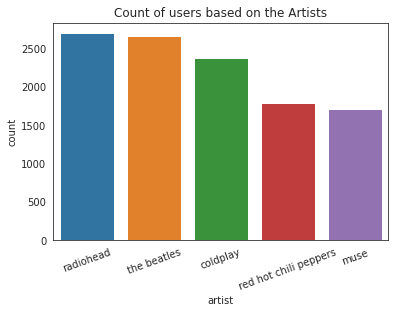

In [ ]:
# Check the count of users based on artist

lastfm_artist = lastfm_data_nounknown.groupby(['artist']).count().sort('count',ascending=False).toPandas().head(5)

sns.barplot(x='artist', y='count', data=lastfm_artist)
plt.xticks(rotation=20)
plt.title('Count of users based on the Artists');

## Now let us save the figure
plt.savefig('Lastfm_Artist.png')

In [ ]:
df1 = lastfm_data_nounknown.select('artist', 'sex').filter(lastfm_data_nounknown.artist == 'radiohead').groupby('artist', 'sex').agg(count('*').alias('count')).orderBy(desc('count')).toPandas()

# Check dataframe
df1

artist sex  count
0  radiohead   m   1982
1  radiohead   f    722

In [ ]:
df2 = lastfm_data_nounknown.select('artist', 'sex').filter(lastfm_data_nounknown.artist == 'the beatles').groupby('artist', 'sex').agg(count('*').alias('count')).orderBy(desc('count')).toPandas()

# Check dataframe
df2

artist sex  count
0  the beatles   m   1908
1  the beatles   f    760

In [ ]:
df3 = lastfm_data_nounknown.select('artist', 'sex').filter(lastfm_data_nounknown.artist == 'coldplay').groupby('artist', 'sex').agg(count('*').alias('count')).orderBy(desc('count')).toPandas()

# Check dataframe
df3

artist sex  count
0  coldplay   m   1580
1  coldplay   f    798

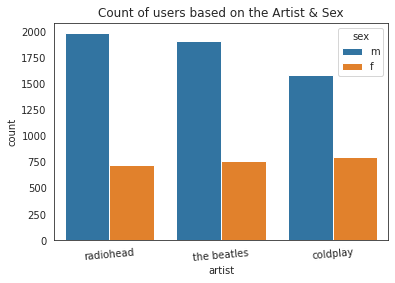

In [ ]:
df_merged1 = df1.append(df2, ignore_index=True)
df_merged1
#frames = [df1, df2, df3]

#result = pd.concat(frames)

df_merged2 = df_merged1.append(df3, ignore_index=True)

df_merged2

sns.barplot(x='artist', y='count', data=df_merged2, hue='sex')
plt.xticks(rotation=5)
plt.title('Count of users based on the Artist & Sex');

## Now let us save the figure
plt.savefig('Lastfm_Artist & Sex.png')



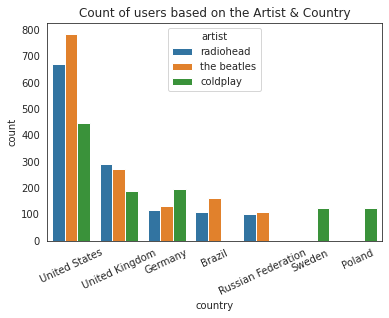

In [ ]:
# Let us analyze the top 3 artists further more based on country
df1 = lastfm_data_nounknown.select('artist', 'country').filter(lastfm_data_nounknown.artist == 'radiohead').groupby('artist', 'country').agg(count('*').alias('count')).orderBy(desc('count')).limit(5).toPandas()

# Check dataframe
df1

df2 = lastfm_data_nounknown.select('artist', 'country').filter(lastfm_data_nounknown.artist == 'the beatles').groupby('artist', 'country').agg(count('*').alias('count')).orderBy(desc('count')).limit(5).toPandas()

# Check dataframe
df2

df3 = lastfm_data_nounknown.select('artist', 'country').filter(lastfm_data_nounknown.artist == 'coldplay').groupby('artist', 'country').agg(count('*').alias('count')).orderBy(desc('count')).limit(5).toPandas()

# Check dataframe
df3


df_merged1 = df1.append(df2, ignore_index=True)
#frames = [df1, df2, df3]

#result = pd.concat(frames)

df_merged2 = df_merged1.append(df3, ignore_index=True)

df_merged2

sns.barplot(x='country', y='count', data=df_merged2, hue='artist')
plt.xticks(rotation=25)
plt.title('Count of users based on the Artist & Country');

## Now let us save the figure
plt.savefig('Lastfm_Artist & Country.png')

# We can see that majority of the listeners of radiohead are from US, UK and Germany, for the beatles it US, UK and Brazil, for coldplay the listeners are from US, Germany, UK

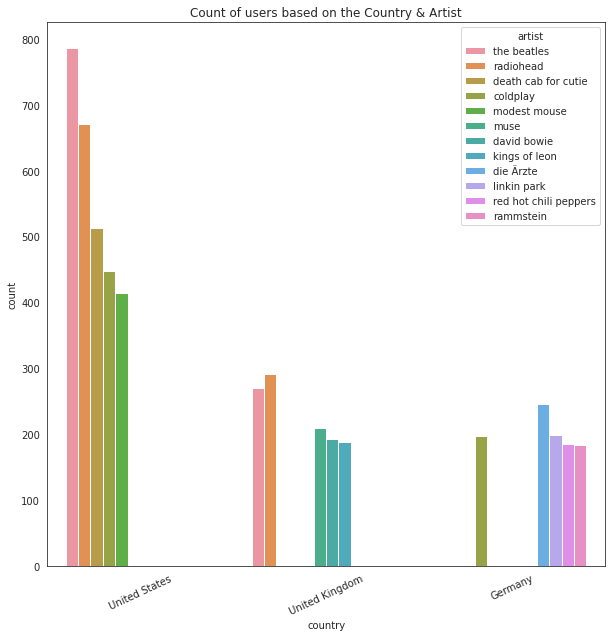

In [ ]:
# Let us analyze the top 3 countries further more based on artists
df1 = lastfm_data_nounknown.select('artist', 'country').filter(lastfm_data_nounknown.country == 'United States').groupby('country', 'artist').agg(count('*').alias('count')).orderBy(desc('count')).limit(5).toPandas()

# Check dataframe
df1

df2 = lastfm_data_nounknown.select('artist', 'country').filter(lastfm_data_nounknown.country == 'United Kingdom').groupby('country', 'artist').agg(count('*').alias('count')).orderBy(desc('count')).limit(5).toPandas()

# Check dataframe
df2

df3 = lastfm_data_nounknown.select('artist', 'country').filter(lastfm_data_nounknown.country == 'Germany').groupby('country', 'artist').agg(count('*').alias('count')).orderBy(desc('count')).limit(5).toPandas()

# Check dataframe
df3

df_merged1 = df1.append(df2, ignore_index=True)
#frames = [df1, df2, df3]

#result = pd.concat(frames)

df_merged2 = df_merged1.append(df3, ignore_index=True)

df_merged2

plt.figure(figsize=(10,10))
sns.barplot(x='country', y='count', data=df_merged2, hue='artist')
plt.xticks(rotation=25)
plt.title('Count of users based on the Country & Artist');

## Now let us save the figure
plt.savefig('Lastfm_Artist & Country.png')

# We can see that majority of the listeners of radiohead are from US, UK and Germany, for the beatles it US, UK and Brazil, for coldplay the listeners are from US, Germany, UK

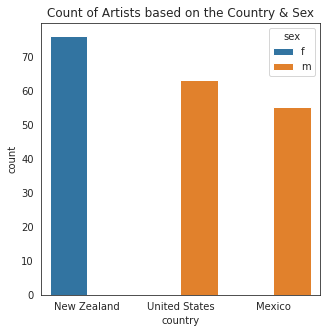

In [ ]:
#Top 3 users which country they are from, their sex and count of artists they have listened to
df1 = lastfm_data_nounknown.select('user', 'country', 'sex').filter(lastfm_data_nounknown.user == 17681) .groupby('user','country', 'sex').agg(count('*').alias('count')).orderBy(desc('count')).limit(5).toPandas()


# Check dataframe
df1

df2 = lastfm_data_nounknown.select('user','country', 'sex').filter(lastfm_data_nounknown.user == 15057) .groupby('user','country', 'sex').agg(count('*').alias('count')).orderBy(desc('count')).limit(5).toPandas()

# Check dataframe
df2

df3 = lastfm_data_nounknown.select('user', 'country', 'sex').filter(lastfm_data_nounknown.user == 1208) .groupby('user','country', 'sex').agg(count('*').alias('count')).orderBy(desc('count')).limit(5).toPandas()

# Check dataframe
df3

df_merged1 = df1.append(df2, ignore_index=True)
#frames = [df1, df2, df3]

#result = pd.concat(frames)

df_merged2 = df_merged1.append(df3, ignore_index=True)

df_merged2

plt.figure(figsize=(5,5))
sns.barplot(x='country', y='count', data=df_merged2, hue='sex')
#plt.xticks(rotation=25)
plt.title('Count of Artists based on the Country & Sex');

## Now let us save the figure
plt.savefig('Lastfm_Country & Sex.png')


In [ ]:
artist_counts = lastfm_data_nounknown_pd.groupby('artist')['user'].count().reset_index().rename(columns = {'user':'frequency'})
artist_counts = artist_counts.sort_values('frequency', ascending=False)[0:100].reset_index(drop=True)
artist_counts.head(10)

artist  frequency
0              radiohead       2704
1            the beatles       2668
2               coldplay       2378
3  red hot chili peppers       1786
4                   muse       1711
5              metallica       1670
6             pink floyd       1574
7            linkin park       1473
8                nirvana       1473
9            the killers       1473

# **Apriori Algorithm Data Transformation, Partitioning & Tuning**






In [ ]:
#We need to select the columns for the Apriori algorithm (user and artist)
lastfm_data_nounknown_ap = lastfm_data_nounknown_pd[['user','artist']]
lastfm_data_nounknown_ap
#print(type(lastfm_data_nounknown_ap))
#lastfm_data_nounknown_ap.count()

df = pd.DataFrame(lastfm_data_nounknown_ap)
df
#df.dtypes

user                    artist
0          19                  le tigre
1          28  rage against the machine
2          47             john coltrane
3          64              trentemøller
4          74                   sirenia
...       ...                       ...
289395  19675             enter shikari
289396  19676                 bob dylan
289397  19677              jack johnson
289398  19683              cypress hill
289399  19697               fatboy slim

[289400 rows x 2 columns]

In [ ]:
#Shuffling the rows before the split
lastfm_data_nounknown_ap = lastfm_data_nounknown_ap.sample(frac = 1)
lastfm_data_nounknown_ap

#Splitting the data in 2 sets train and test. Train set have 60% of the values of original dataframe. Random state allows to bring repeatability

train_ap = lastfm_data_nounknown_ap.sample(frac = 0.6, random_state=200) 
print(train_ap.count())

#Test set have 40% of the values of original dataframe
test_ap= df.drop(train_ap.index)
print(test_ap.count())

user      173640
artist    173640
dtype: int64
user      115760
artist    115760
dtype: int64


In [ ]:
# Creating a list of train dataset
lastfm_transactions_train = []
for i in train_ap['user'].unique():
    lastfm_transactions_train.append(list(train_ap[train_ap['user'] == i]['artist'].values))

lastfm_transactions_train
#print(type(lastfm_transactions))
#len(lastfm_transactions)


[['madonna',
  'alicia keys',
  'moby',
  'u2',
  'foo fighters',
  'the strokes',
  'justice',
  'red hot chili peppers',
  'keane',
  'jem',
  'radiohead',
  'incubus',
  'lily allen',
  'placebo',
  'blur',
  'jamiroquai',
  'sublime',
  'muse',
  'robbie williams',
  'the rolling stones',
  'dido',
  'alanis morissette',
  't.a.t.u.',
  'arctic monkeys',
  'james blunt'],
 ['blink-182',
  'something corporate',
  'mae',
  'maroon 5',
  'the ataris',
  'the all-american rejects',
  'miley cyrus',
  'snow patrol',
  'backstreet boys',
  'sugarcult',
  'sum 41',
  'madonna',
  'jimmy eat world',
  'hilary duff',
  'boys like girls'],
 ['imogen heap',
  'cat power',
  'pinback',
  'broken social scene',
  'modest mouse',
  'peaches',
  'the rapture',
  'fischerspooner',
  'goldfrapp',
  'lcd soundsystem',
  'band of horses',
  'mew',
  'metric',
  'ladytron',
  'daft punk',
  'm.i.a.',
  'damien rice',
  'the faint',
  'chromeo',
  'cut copy',
  'm83',
  'bloc party',
  'radiohead',
  

In [ ]:
# Creating a list of test dataset
lastfm_transactions_test = []
for i in test_ap['user'].unique():
    lastfm_transactions_test.append(list(test_ap[test_ap['user'] == i]['artist'].values))

lastfm_transactions_test

[['john coltrane',
  'kate bush',
  'johnny cash',
  'pink martini',
  'emilíana torrini',
  'the velvet underground',
  'morcheeba',
  'blonde redhead',
  'nick cave and the bad seeds',
  'einstürzende neubauten',
  'bob dylan',
  'björk',
  'pj harvey',
  'air'],
 ['trentemøller', 'underworld', 'alexisonfire'],
 ['johnny cash',
  'the brian jonestown massacre',
  'marilyn manson',
  'talking heads',
  'iggy pop',
  'nick cave and the bad seeds',
  'armin van buuren',
  'captain beefheart & his magic band',
  'nirvana',
  'the smashing pumpkins'],
 ['madonna',
  'kings of convenience',
  'cut copy',
  'oasis',
  'the rapture',
  'the presets',
  'morphine',
  'st. germain',
  'röyksopp'],
 ['iron maiden',
  'red hot chili peppers',
  'kamelot',
  'journey',
  'phil collins',
  'angra',
  'the beatles',
  'daft punk',
  'sonata arctica',
  'linkin park',
  'green day',
  'cat stevens',
  'scooter',
  'pendulum',
  'therion'],
 ['sarah mclachlan', 'mika', 'Édith piaf'],
 ['fall out boy'

In [ ]:
# Hot encoding to convert the train list for apriori analysis
te_train = TransactionEncoder()
te_ary_train = te_train.fit(lastfm_transactions_train).transform(lastfm_transactions_train)
apriori_df_train = pd.DataFrame(te_ary_train, columns=te_train.columns_)
apriori_df_train

...and you will know us by the trail of dead   2pac  3 doors down  \
0                                             False  False         False   
1                                             False  False         False   
2                                             False  False         False   
3                                             False  False         False   
4                                             False  False         False   
...                                             ...    ...           ...   
14855                                         False  False         False   
14856                                         False  False         False   
14857                                         False  False         False   
14858                                         False  False         False   
14859                                         False  False         False   

       30 seconds to mars    311  36 crazyfists     44  50 cent  \
0                   False  False          False  False    False   
1                   False  False          False  False    False   
2                   False  False          False  False    False   
3                   False  False          False  False    False   
4                   False  False          False  False    False   
...                   ...    ...            ...    ...      ...   
14855               False  False          False  False    False   
14856               False  False          False  False    False   
14857               False  False          False  False    False   
14858               False  False          False  False    False   
14859               False  False          False  False    False   

       65daysofstatic  a day to remember  ...  wilco  within temptation  \
0               False              False  ...  False              False   
1               False              False  ...  False              False   
2               False              False  ...  False              False   
3               False              False  ...  False              False   
4               False              False  ...  False              False   
...               ...                ...  ...    ...                ...   
14855           False              False  ...  False              False   
14856           False              False  ...  False              False   
14857           False              False  ...  False              False   
14858           False              False  ...  False              False   
14859           False              False  ...  False              False   

       wolfgang amadeus mozart  wu-tang clan  yann tiersen  yeah yeah yeahs  \
0                        False         False         False            False   
1                        False         False         False            False   
2                        False         False         False            False   
3                        False         False         False            False   
4                        False         False         False            False   
...                        ...           ...           ...              ...   
14855                    False         False         False            False   
14856                    False         False         False            False   
14857                    False         False         False            False   
14858                    False         False         False            False   
14859                    False         False         False            False   

       yellowcard  yo la tengo  zero 7  Édith piaf  
0           False        False   False       False  
1           False        False   False       False  
2           False        False   False       False  
3           False        False   False       False  
4           False        False   False       False  
...           ...          ...     ...         ...  
14855       False        False   False       False  
14856       Fal

In [ ]:
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1
    
apriori_df_train = apriori_df_train.applymap(encode_units)
apriori_df_train

...and you will know us by the trail of dead  2pac  3 doors down  \
0                                                 0     0             0   
1                                                 0     0             0   
2                                                 0     0             0   
3                                                 0     0             0   
4                                                 0     0             0   
...                                             ...   ...           ...   
14855                                             0     0             0   
14856                                             0     0             0   
14857                                             0     0             0   
14858                                             0     0             0   
14859                                             0     0             0   

       30 seconds to mars  311  36 crazyfists  44  50 cent  65daysofstatic  \
0                       0    0              0   0        0               0   
1                       0    0              0   0        0               0   
2                       0    0              0   0        0               0   
3                       0    0              0   0        0               0   
4                       0    0              0   0        0               0   
...                   ...  ...            ...  ..      ...             ...   
14855                   0    0              0   0        0               0   
14856                   0    0              0   0        0               0   
14857                   0    0              0   0        0               0   
14858                   0    0              0   0        0               0   
14859                   0    0              0   0        0               0   

       a day to remember  ...  wilco  within temptation  \
0                      0  ...      0                  0   
1                      0  ...      0                  0   
2                      0  ...      0                  0   
3                      0  ...      0                  0   
4                      0  ...      0                  0   
...                  ...  ...    ...                ...   
14855                  0  ...      0                  0   
14856                  0  ...      0                  0   
14857                  0  ...      0                  0   
14858                  0  ...      0                  0   
14859                  0  ...      0                  0   

       wolfgang amadeus mozart  wu-tang clan  yann tiersen  yeah yeah yeahs  \
0                            0             0             0                0   
1                            0             0             0                0   
2                            0             0             0                0   
3                            0             0             0                0   
4                            0             0             0                0   
...                        ...           ...           ...              ...   
14855                        0             0             0                0   
14856                        0             0             0                0   
14857                        0             0             0                0   
14858                        0             0             0                0   
14859                        0             0             0                0   

       yellowcard  yo la tengo  zero 7  Édith piaf  
0               0            0       0           0  
1               0            0       0           0  
2               0            0       0           0  
3               0            0       0           0  
4               0            0       0           0  
...           ...          ...     ...         ...  
14855           0            0       0           0  
14856           0            0       0           0  
14857           0            0    

In [ ]:
# Hot encoding to convert the test list for apriori analysis
te_test = TransactionEncoder()
te_ary_test = te_test.fit(lastfm_transactions_test).transform(lastfm_transactions_test)
apriori_df_test = pd.DataFrame(te_ary_test, columns=te_test.columns_)
apriori_df_test

...and you will know us by the trail of dead   2pac  3 doors down  \
0                                             False  False         False   
1                                             False  False         False   
2                                             False  False         False   
3                                             False  False         False   
4                                             False  False         False   
...                                             ...    ...           ...   
14608                                         False  False         False   
14609                                         False  False         False   
14610                                         False  False         False   
14611                                         False  False         False   
14612                                         False  False         False   

       30 seconds to mars    311  36 crazyfists     44  50 cent  \
0                   False  False          False  False    False   
1                   False  False          False  False    False   
2                   False  False          False  False    False   
3                   False  False          False  False    False   
4                   False  False          False  False    False   
...                   ...    ...            ...    ...      ...   
14608               False  False          False  False    False   
14609               False  False          False  False    False   
14610               False  False          False  False    False   
14611               False  False          False  False    False   
14612               False  False          False  False    False   

       65daysofstatic  a day to remember  ...  wilco  within temptation  \
0               False              False  ...  False              False   
1               False              False  ...  False              False   
2               False              False  ...  False              False   
3               False              False  ...  False              False   
4               False              False  ...  False              False   
...               ...                ...  ...    ...                ...   
14608           False              False  ...  False              False   
14609           False              False  ...  False              False   
14610           False              False  ...  False              False   
14611           False              False  ...  False              False   
14612           False              False  ...  False              False   

       wolfgang amadeus mozart  wu-tang clan  yann tiersen  yeah yeah yeahs  \
0                        False         False         False            False   
1                        False         False         False            False   
2                        False         False         False            False   
3                        False         False         False            False   
4                        False         False         False            False   
...                        ...           ...           ...              ...   
14608                    False         False         False            False   
14609                    False         False         False            False   
14610                    False         False         False            False   
14611                    False         False         False            False   
14612                    False         False         False            False   

       yellowcard  yo la tengo  zero 7  Édith piaf  
0           False        False   False       False  
1           False        False   False       False  
2           False        False   False       False  
3           False        False   False       False  
4           False        False   False       False  
...           ...          ...     ...         ...  
14608       False        False   False       False  
14609       Fal

In [ ]:
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1:
        return 1
    
apriori_df_test = apriori_df_test.applymap(encode_units)
apriori_df_test

...and you will know us by the trail of dead  2pac  3 doors down  \
0                                                 0     0             0   
1                                                 0     0             0   
2                                                 0     0             0   
3                                                 0     0             0   
4                                                 0     0             0   
...                                             ...   ...           ...   
14608                                             0     0             0   
14609                                             0     0             0   
14610                                             0     0             0   
14611                                             0     0             0   
14612                                             0     0             0   

       30 seconds to mars  311  36 crazyfists  44  50 cent  65daysofstatic  \
0                       0    0              0   0        0               0   
1                       0    0              0   0        0               0   
2                       0    0              0   0        0               0   
3                       0    0              0   0        0               0   
4                       0    0              0   0        0               0   
...                   ...  ...            ...  ..      ...             ...   
14608                   0    0              0   0        0               0   
14609                   0    0              0   0        0               0   
14610                   0    0              0   0        0               0   
14611                   0    0              0   0        0               0   
14612                   0    0              0   0        0               0   

       a day to remember  ...  wilco  within temptation  \
0                      0  ...      0                  0   
1                      0  ...      0                  0   
2                      0  ...      0                  0   
3                      0  ...      0                  0   
4                      0  ...      0                  0   
...                  ...  ...    ...                ...   
14608                  0  ...      0                  0   
14609                  0  ...      0                  0   
14610                  0  ...      0                  0   
14611                  0  ...      0                  0   
14612                  0  ...      0                  0   

       wolfgang amadeus mozart  wu-tang clan  yann tiersen  yeah yeah yeahs  \
0                            0             0             0                0   
1                            0             0             0                0   
2                            0             0             0                0   
3                            0             0             0                0   
4                            0             0             0                0   
...                        ...           ...           ...              ...   
14608                        0             0             0                0   
14609                        0             0             0                0   
14610                        0             0             0                0   
14611                        0             0             0                0   
14612                        0             0             0                0   

       yellowcard  yo la tengo  zero 7  Édith piaf  
0               0            0       0           0  
1               0            0       0           0  
2               0            0       0           0  
3               0            0       0           0  
4               0            0       0           0  
...           ...          ...     ...         ...  
14608           0            0       0           0  
14609           0            0       0           0  
14610           0            0    

##**Minimum Support 0.002 and Multiple Confidence Levels Tuning**.






In [ ]:
# Analyzing the results from Apriori on Train Dataset
frequent_items_train = apriori(apriori_df_train, min_support=0.002, use_colnames=True)
frequent_items_train.head()

# Set the min support to 0.002 as less than that the apriori is very slow given the large train dataset size even after partitioning

support                                        itemsets
0  0.006057  (...and you will know us by the trail of dead)
1  0.013930                                          (2pac)
2  0.018102                                  (3 doors down)
3  0.019179                            (30 seconds to mars)
4  0.005182                                           (311)

In [ ]:
len(frequent_items_train)

5181

In [ ]:
rules = association_rules(frequent_items_train, metric='confidence', min_threshold=0.20)
rules = rules.sort_values(['confidence', 'lift'], ascending =[False, False])
rules

# Arranging with highest confidence and lift

# Started with minimum confidence of  20%


antecedents      consequents  antecedent support  \
581               (tarja turunen)      (nightwish)            0.004172   
993   (queen, the rolling stones)    (the beatles)            0.004845   
1002  (the shins, sufjan stevens)      (radiohead)            0.005047   
917    (iron maiden, the beatles)      (metallica)            0.004374   
874             (u2, the killers)       (coldplay)            0.005653   
...                           ...              ...                 ...   
123                (mariah carey)        (beyoncé)            0.011440   
437                 (maxïmo park)  (kaiser chiefs)            0.011440   
323       (explosions in the sky)         (mogwai)            0.016151   
556                   (morrissey)       (the cure)            0.014805   
458                   (katatonia)      (metallica)            0.011440   

      consequent support   support  confidence       lift  leverage  \
581             0.037483  0.002086    0.500000  13.339318  0.001930   
993             0.108345  0.002355    0.486111   4.486715  0.001830   
1002            0.105922  0.002423    0.480000   4.531639  0.001888   
917             0.067429  0.002019    0.461538   6.844772  0.001724   
874             0.096030  0.002557    0.452381   4.710849  0.002014   
...                  ...       ...         ...        ...       ...   
123             0.017093  0.002288    0.200000  11.700787  0.002092   
437             0.018641  0.002288    0.200000  10.729242  0.002075   
323             0.021938  0.003230    0.200000   9.116564  0.002876   
556             0.045020  0.002961    0.200000   4.442451  0.002294   
458             0.067429  0.002288    0.200000   2.966068  0.001517   

      conviction  
581     1.925034  
993     1.735113  
1002    1.719381  
917     1.731917  
874     1.650729  
...          ...  
123     1.228634  
437     1.226699  
323     1.222577  
556     1.193725  
458     1.165713  

[1018 rows x 9 columns]

In [ ]:
len(rules)

1018

In [ ]:
rules = association_rules(frequent_items_train, metric='confidence', min_threshold=0.25)
rules = rules.sort_values(['confidence', 'lift'], ascending =[False, False])
rules

antecedents    consequents  antecedent support  \
221                     (tarja turunen)    (nightwish)            0.004172   
451         (queen, the rolling stones)  (the beatles)            0.004845   
458         (the shins, sufjan stevens)    (radiohead)            0.005047   
402          (iron maiden, the beatles)    (metallica)            0.004374   
373                   (u2, the killers)     (coldplay)            0.005653   
..                                  ...            ...                 ...   
201                               (m83)    (radiohead)            0.012651   
238                             (stars)    (radiohead)            0.012382   
43                         (billy joel)  (the beatles)            0.008614   
263                         (the doors)  (the beatles)            0.034993   
456  (red hot chili peppers, radiohead)  (the beatles)            0.011575   

     consequent support   support  confidence       lift  leverage  conviction  
221            0.037483  0.002086    0.500000  13.339318  0.001930    1.925034  
451            0.108345  0.002355    0.486111   4.486715  0.001830    1.735113  
458            0.105922  0.002423    0.480000   4.531639  0.001888    1.719381  
402            0.067429  0.002019    0.461538   6.844772  0.001724    1.731917  
373            0.096030  0.002557    0.452381   4.710849  0.002014    1.650729  
..                  ...       ...         ...        ...       ...         ...  
201            0.105922  0.003163    0.250000   2.360229  0.001823    1.192104  
238            0.105922  0.003096    0.250000   2.360229  0.001784    1.192104  
43             0.108345  0.002153    0.250000   2.307453  0.001220    1.188874  
263            0.108345  0.008748    0.250000   2.307453  0.004957    1.188874  
456            0.108345  0.002894    0.250000   2.307453  0.001640    1.188874  

[471 rows x 9 columns]

In [ ]:
len(rules)

471

In [ ]:
rules = association_rules(frequent_items_train, metric='confidence', min_threshold=0.30)
rules = rules.sort_values(['confidence', 'lift'], ascending =[False, False])
rules

antecedents              consequents  \
63                       (tarja turunen)              (nightwish)   
188          (queen, the rolling stones)            (the beatles)   
192          (the shins, sufjan stevens)              (radiohead)   
160           (iron maiden, the beatles)              (metallica)   
141                    (u2, the killers)               (coldplay)   
..                                   ...                      ...   
59                              (slayer)              (metallica)   
45                       (josé gonzález)              (radiohead)   
151          (foo fighters, the beatles)  (red hot chili peppers)   
97             (the killers, bloc party)               (coldplay)   
146  (death cab for cutie, modest mouse)              (radiohead)   

     antecedent support  consequent support   support  confidence       lift  \
63             0.004172            0.037483  0.002086    0.500000  13.339318   
188            0.004845            0.108345  0.002355    0.486111   4.486715   
192            0.005047            0.105922  0.002423    0.480000   4.531639   
160            0.004374            0.067429  0.002019    0.461538   6.844772   
141            0.005653            0.096030  0.002557    0.452381   4.710849   
..                  ...                 ...       ...         ...        ...   
59             0.019246            0.067429  0.005787    0.300699   4.459473   
45             0.016353            0.105922  0.004913    0.300412   2.836160   
151            0.006729            0.071736  0.002019    0.300000   4.181989   
97             0.008075            0.096030  0.002423    0.300000   3.124036   
146            0.006729            0.105922  0.002019    0.300000   2.832274   

     leverage  conviction  
63   0.001930    1.925034  
188  0.001830    1.735113  
192  0.001888    1.719381  
160  0.001724    1.731917  
141  0.002014    1.650729  
..        ...         ...  
59   0.004490    1.333576  
45   0.003180    1.278006  
151  0.001536    1.326091  
97   0.001647    1.291386  
146  0.001306    1.277254  

[198 rows x 9 columns]

In [ ]:
len(rules)

198

In [ ]:
rules = association_rules(frequent_items_train, metric='confidence', min_threshold=0.40)
rules = rules.sort_values(['confidence', 'lift'], ascending =[False, False])
rules

antecedents                consequents  \
2                          (tarja turunen)                (nightwish)   
25             (queen, the rolling stones)              (the beatles)   
27             (the shins, sufjan stevens)                (radiohead)   
19              (iron maiden, the beatles)                (metallica)   
15                       (u2, the killers)                 (coldplay)   
18         (system of a down, iron maiden)                (metallica)   
6                   (the clash, bob dylan)              (the beatles)   
11                    (oasis, the killers)                 (coldplay)   
7           (the white stripes, bob dylan)              (the beatles)   
10                    (oasis, the beatles)                 (coldplay)   
8       (death cab for cutie, snow patrol)                 (coldplay)   
14          (coldplay, the rolling stones)              (the beatles)   
3                     (ac/dc, iron maiden)                (metallica)   
4                          (coldplay, air)                (radiohead)   
12              (the killers, snow patrol)                 (coldplay)   
17               (pink floyd, iron maiden)                (metallica)   
22                   (queen, led zeppelin)               (pink floyd)   
24       (the white stripes, led zeppelin)              (the beatles)   
26  (queens of the stone age, the beatles)                (radiohead)   
21                    (muse, led zeppelin)              (the beatles)   
23      (the rolling stones, led zeppelin)              (the beatles)   
5                  (the kooks, bloc party)           (arctic monkeys)   
0                  (eagles of death metal)  (queens of the stone age)   
16               (pink floyd, david bowie)              (the beatles)   
20             (jimi hendrix, the beatles)             (led zeppelin)   
1                                  (epica)                (nightwish)   
9                    (the shins, coldplay)      (death cab for cutie)   
13              (the killers, the beatles)                 (coldplay)   

    antecedent support  consequent support   support  confidence       lift  \
2             0.004172            0.037483  0.002086    0.500000  13.339318   
25            0.004845            0.108345  0.002355    0.486111   4.486715   
27            0.005047            0.105922  0.002423    0.480000   4.531639   
19            0.004374            0.067429  0.002019    0.461538   6.844772   
15            0.005653            0.096030  0.002557    0.452381   4.710849   
18            0.004980            0.067429  0.002221    0.445946   6.613530   
6             0.004845            0.108345  0.002153    0.444444   4.102139   
11            0.006528            0.096030  0.002894    0.443299   4.616274   
7             0.004711            0.108345  0.002086    0.442857   4.087489   
10            0.007739            0.096030  0.003365    0.434783   4.527589   
8             0.004980            0.096030  0.002153    0.432432   4.503116   
14            0.005047            0.108345  0.002153    0.426667   3.938054   
3             0.005855            0.067429  0.002490    0.425287   6.307156   
4             0.005922            0.105922  0.002490    0.420455   3.969476   
12            0.006258            0.096030  0.002624    0.419355   4.366933   
17            0.005316            0.067429  0.002221    0.417722   6.194952   
22            0.005653            0.063795  0.002355    0.416667   6.531294   
24            0.005989            0.108345  0.002490    0.415730   3.837114   
26            0.005047            0.105922  0.002086    0.413333   3.902245   
21            0.005047            0.108345  0.002086    0.413333   3.814990   
23            0.007672            0.108345  0.003163    0.412281   3.805274   
5             0.004913            0.045357  0.002019    0.410959   9.060607   
0             0.005585            0.030081  0.002288    0.409639  13.617962   
16            0.0

In [ ]:
len(rules)

28

In [ ]:
rules = association_rules(frequent_items_train, metric='confidence', min_threshold=0.45)
rules = rules.sort_values(['confidence', 'lift'], ascending =[False, False])
rules

# The maximum confidence level on the train dataset is 45%

antecedents    consequents  antecedent support  \
0              (tarja turunen)    (nightwish)            0.004172   
3  (queen, the rolling stones)  (the beatles)            0.004845   
4  (the shins, sufjan stevens)    (radiohead)            0.005047   
2   (iron maiden, the beatles)    (metallica)            0.004374   
1            (u2, the killers)     (coldplay)            0.005653   

   consequent support   support  confidence       lift  leverage  conviction  
0            0.037483  0.002086    0.500000  13.339318  0.001930    1.925034  
3            0.108345  0.002355    0.486111   4.486715  0.001830    1.735113  
4            0.105922  0.002423    0.480000   4.531639  0.001888    1.719381  
2            0.067429  0.002019    0.461538   6.844772  0.001724    1.731917  
1            0.096030  0.002557    0.452381   4.710849  0.002014    1.650729

In [ ]:
len(rules)

5

In [ ]:
rules = association_rules(frequent_items_train, metric='confidence', min_threshold=0.5)
rules = rules.sort_values(['confidence', 'lift'], ascending =[False, False])
rules

antecedents  consequents  antecedent support  consequent support  \
0  (tarja turunen)  (nightwish)            0.004172            0.037483   

    support  confidence       lift  leverage  conviction  
0  0.002086         0.5  13.339318   0.00193    1.925034

In [ ]:
len(rules)

1

In [ ]:
rules = association_rules(frequent_items_train, metric='confidence', min_threshold=0.6)
rules = rules.sort_values(['confidence', 'lift'], ascending =[False, False])
rules

Empty DataFrame
Columns: [antecedents, consequents, antecedent support, consequent support, support, confidence, lift, leverage, conviction]
Index: []

In [ ]:
len(rules)

0

In [ ]:
# Analyze and Evaluate the results from Apriori on Test Dataset

frequent_items_test = apriori(apriori_df_test, min_support=0.002, use_colnames=True)
frequent_items_test.head()

# We tried min_support multiple values and observed that for 0.01 and 0.1 there are no associations in test dataset. We will use 0.001 in this case

# Frequent items in test and train sets are same so our model is working fine

support                                        itemsets
0  0.003901  (...and you will know us by the trail of dead)
1  0.009170                                          (2pac)
2  0.013344                                  (3 doors down)
3  0.014165                            (30 seconds to mars)
4  0.003285                                           (311)

In [ ]:
len(frequent_items_test)

1617

In [ ]:
rules = association_rules(frequent_items_test, metric='confidence', min_threshold=0.20)
rules = rules.sort_values(['confidence', 'lift'], ascending =[False, False])
rules

antecedents            consequents  antecedent support  \
10                  (keane)             (coldplay)            0.014576   
28       (the flaming lips)            (radiohead)            0.010265   
30        (tv on the radio)            (radiohead)            0.008691   
22                 (mogwai)            (radiohead)            0.013481   
23         (sonata arctica)            (nightwish)            0.011086   
32       (the flaming lips)          (the beatles)            0.010265   
4                    (blur)            (radiohead)            0.013960   
20          (kylie minogue)              (madonna)            0.008759   
7       (breaking benjamin)          (linkin park)            0.010470   
1       (animal collective)            (radiohead)            0.015671   
9     (broken social scene)            (radiohead)            0.011839   
31       (the decemberists)          (the beatles)            0.014234   
26              (sigur rós)            (radiohead)            0.028810   
33              (the kinks)          (the beatles)            0.011018   
15                   (eels)            (radiohead)            0.008965   
12                 (travis)             (coldplay)            0.010812   
2                    (beck)            (radiohead)            0.022377   
14                (editors)            (radiohead)            0.009375   
18          (kaiser chiefs)          (the killers)            0.013139   
8     (broken social scene)  (death cab for cutie)            0.011839   
11            (snow patrol)             (coldplay)            0.018887   
25             (portishead)            (radiohead)            0.027852   
0        (a perfect circle)            (radiohead)            0.014439   
34     (the rolling stones)          (the beatles)            0.024362   
29  (the smashing pumpkins)            (radiohead)            0.024430   
6                (bon iver)            (radiohead)            0.010607   
3           (black sabbath)            (metallica)            0.014644   
13              (the shins)  (death cab for cutie)            0.020735   
24              (pj harvey)            (radiohead)            0.012728   
16          (kaiser chiefs)      (franz ferdinand)            0.013139   
19                   (koЯn)     (system of a down)            0.018614   
35                (the who)          (the beatles)            0.013892   
27            (sonic youth)            (radiohead)            0.015329   
17               (interpol)            (radiohead)            0.020803   
21                (pantera)            (metallica)            0.011633   
5        (boards of canada)            (radiohead)            0.017108   

    consequent support   support  confidence      lift  leverage  conviction  
10            0.065079  0.004653    0.319249  4.905555  0.003705    1.373367  
28            0.077328  0.002669    0.260000  3.362283  0.001875    1.246854  
30            0.077328  0.002258    0.259843  3.360247  0.001586    1.246588  
22            0.077328  0.003422    0.253807  3.282198  0.002379    1.236505  
23            0.025457  0.002737    0.246914  9.699323  0.002455    1.294066  
32            0.072401  0.002532    0.246667  3.406938  0.001789    1.231326  
4             0.077328  0.003422    0.245098  3.169573  0.002342    1.222240  
20            0.024909  0.002121    0.242188  9.722764  0.001903    1.286718  
7             0.040854  0.002464    0.235294  5.759385  0.002036    1.254268  
1             0.077328  0.003627    0.231441  2.992963  0.002415    1.200522  
9             0.077328  0.002737    0.231214  2.990025  0.001822    1.200167  
31            0.072401  0.003285    0.230769  3.187364  0.002254    1.205878  
26            0.077328  0.006638    0.230404  2.979549  0.004410    1.198904  
33            0.072401  0.002532    0.229814  3.174165  0.001734    1.204382  
15            0.077328  0.002053    0.229008  2.961494  0.001360    1.196732  
12           

In [ ]:
len(rules)

36

In [ ]:
rules = association_rules(frequent_items_test, metric='confidence', min_threshold=0.25)
rules = rules.sort_values(['confidence', 'lift'], ascending =[False, False])
rules

# With a support 0.002 and confidence 25% we have received we have received 4 rules that applies to signifcant number of baskets


antecedents  consequents  antecedent support  consequent support  \
0             (keane)   (coldplay)            0.014576            0.065079   
2  (the flaming lips)  (radiohead)            0.010265            0.077328   
3   (tv on the radio)  (radiohead)            0.008691            0.077328   
1            (mogwai)  (radiohead)            0.013481            0.077328   

    support  confidence      lift  leverage  conviction  
0  0.004653    0.319249  4.905555  0.003705    1.373367  
2  0.002669    0.260000  3.362283  0.001875    1.246854  
3  0.002258    0.259843  3.360247  0.001586    1.246588  
1  0.003422    0.253807  3.282198  0.002379    1.236505

In [ ]:
len(rules)

4

In [ ]:
rules = association_rules(frequent_items_test, metric='confidence', min_threshold=0.3)
rules = rules.sort_values(['confidence', 'lift'], ascending =[False, False])
rules


antecedents consequents  antecedent support  consequent support   support  \
0     (keane)  (coldplay)            0.014576            0.065079  0.004653   

   confidence      lift  leverage  conviction  
0    0.319249  4.905555  0.003705    1.373367

In [ ]:
len(rules)

1

In [ ]:
rules = association_rules(frequent_items_test, metric='confidence', min_threshold=0.4)
rules = rules.sort_values(['confidence', 'lift'], ascending =[False, False])
rules

# There are no association rules with min support 0.002 and confidence level more than 40% on the test dataset

Empty DataFrame
Columns: [antecedents, consequents, antecedent support, consequent support, support, confidence, lift, leverage, conviction]
Index: []

In [ ]:
len(rules)

0

##**Minimum Support 0.003 and Multiple Confidence Levels Tuning**




In [ ]:
# Analyzing the results from Apriori on Train Dataset with min support as 0.003

frequent_items_train = apriori(apriori_df_train, min_support=0.003, use_colnames=True)
frequent_items_train.head()

support                                        itemsets
0  0.006057  (...and you will know us by the trail of dead)
1  0.013930                                          (2pac)
2  0.018102                                  (3 doors down)
3  0.019179                            (30 seconds to mars)
4  0.005182                                           (311)

In [ ]:
len(frequent_items_train)

2587

In [ ]:
rules = association_rules(frequent_items_train, metric='confidence', min_threshold=0.2)
rules = rules.sort_values(['confidence', 'lift'], ascending =[False, False])
rules

# Arranging with highest confidence and lift

antecedents       consequents  antecedent support  \
372                (oasis, the beatles)        (coldplay)            0.007739   
388  (the rolling stones, led zeppelin)     (the beatles)            0.007672   
165                             (epica)       (nightwish)            0.008143   
382          (the killers, the beatles)        (coldplay)            0.008883   
196                          (soilwork)       (in flames)            0.009287   
..                                  ...               ...                 ...   
255                         (morcheeba)  (massive attack)            0.016083   
69                  (bruce springsteen)       (bob dylan)            0.017093   
182                   (franz ferdinand)            (muse)            0.034859   
254                    (marilyn manson)       (rammstein)            0.027860   
167             (explosions in the sky)          (mogwai)            0.016151   

     consequent support   support  confidence       lift  leverage  conviction  
372            0.096030  0.003365    0.434783   4.527589  0.002622    1.599332  
388            0.108345  0.003163    0.412281   3.805274  0.002332    1.517145  
165            0.037483  0.003297    0.404959  10.803745  0.002992    1.617563  
382            0.096030  0.003567    0.401515   4.181160  0.002714    1.510432  
196            0.030821  0.003432    0.369565  11.990697  0.003146    1.537318  
..                  ...       ...         ...        ...       ...         ...  
255            0.038022  0.003230    0.200837   5.282186  0.002619    1.203732  
69             0.043607  0.003432    0.200787   4.604477  0.002687    1.196669  
182            0.068641  0.006999    0.200772   2.924975  0.004606    1.165324  
254            0.043069  0.005585    0.200483   4.654967  0.004386    1.196887  
167            0.021938  0.003230    0.200000   9.116564  0.002876    1.222577  

[395 rows x 9 columns]

In [ ]:
len(rules)

395

In [ ]:
rules = association_rules(frequent_items_train, metric='confidence', min_threshold=0.25)
rules = rules.sort_values(['confidence', 'lift'], ascending =[False, False])
rules

antecedents       consequents  antecedent support  \
148                (oasis, the beatles)        (coldplay)            0.007739   
158  (the rolling stones, led zeppelin)     (the beatles)            0.007672   
66                              (epica)       (nightwish)            0.008143   
152          (the killers, the beatles)        (coldplay)            0.008883   
76                           (soilwork)       (in flames)            0.009287   
..                                  ...               ...                 ...   
110                      (modest mouse)       (radiohead)            0.031157   
12                     (the libertines)  (arctic monkeys)            0.012113   
103                               (m83)       (radiohead)            0.012651   
122                             (stars)       (radiohead)            0.012382   
135                         (the doors)     (the beatles)            0.034993   

     consequent support   support  confidence       lift  leverage  conviction  
148            0.096030  0.003365    0.434783   4.527589  0.002622    1.599332  
158            0.108345  0.003163    0.412281   3.805274  0.002332    1.517145  
66             0.037483  0.003297    0.404959  10.803745  0.002992    1.617563  
152            0.096030  0.003567    0.401515   4.181160  0.002714    1.510432  
76             0.030821  0.003432    0.369565  11.990697  0.003146    1.537318  
..                  ...       ...         ...        ...       ...         ...  
110            0.105922  0.007806    0.250540   2.365326  0.004506    1.192963  
12             0.045357  0.003028    0.250000   5.511869  0.002479    1.272858  
103            0.105922  0.003163    0.250000   2.360229  0.001823    1.192104  
122            0.105922  0.003096    0.250000   2.360229  0.001784    1.192104  
135            0.108345  0.008748    0.250000   2.307453  0.004957    1.188874  

[163 rows x 9 columns]

In [ ]:
len(rules)

163

In [ ]:
rules = association_rules(frequent_items_train, metric='confidence', min_threshold=0.3)
rules = rules.sort_values(['confidence', 'lift'], ascending =[False, False])
rules

antecedents         consequents  \
46                (oasis, the beatles)          (coldplay)   
51  (the rolling stones, led zeppelin)       (the beatles)   
14                             (epica)         (nightwish)   
47          (the killers, the beatles)          (coldplay)   
16                          (soilwork)         (in flames)   
23                         (lil wayne)        (kanye west)   
12                            (travis)          (coldplay)   
1                       (squarepusher)        (aphex twin)   
20                       (john lennon)       (the beatles)   
8                              (keane)          (coldplay)   
45                   (coldplay, oasis)       (the beatles)   
19                             (jay-z)        (kanye west)   
38                 (simon & garfunkel)       (the beatles)   
37                      (serj tankian)  (system of a down)   
48            (radiohead, david bowie)       (the beatles)   
39                         (the kinks)       (the beatles)   
26                          (megadeth)         (metallica)   
10                     (stereophonics)          (coldplay)   
17                      (judas priest)       (iron maiden)   
22                      (judas priest)         (metallica)   
44                 (muse, the killers)          (coldplay)   
11                         (the verve)          (coldplay)   
24                       (lupe fiasco)        (kanye west)   
42                           (the who)       (the beatles)   
5                 (the pussycat dolls)    (britney spears)   
41            (the velvet underground)       (the beatles)   
34                  (the flaming lips)         (radiohead)   
7                         (jason mraz)          (coldplay)   
50         (led zeppelin, the beatles)        (pink floyd)   
30                           (trivium)         (metallica)   
27                     (ozzy osbourne)         (metallica)   
15                         (helloween)       (iron maiden)   
32                             (spoon)         (radiohead)   
36                (the pussycat dolls)           (rihanna)   
35                   (tv on the radio)         (radiohead)   
49          (pink floyd, led zeppelin)       (the beatles)   
43  (death cab for cutie, the beatles)          (coldplay)   
18                       (iron maiden)         (metallica)   
3                               (beck)         (radiohead)   
2                        (arcade fire)         (radiohead)   
31                         (sigur rós)         (radiohead)   
13                 (dark tranquillity)         (in flames)   
25                              (t.i.)        (kanye west)   
9                        (snow patrol)          (coldplay)   
4                 (the pussycat dolls)           (beyoncé)   
28                           (pantera)         (metallica)   
6                               (cake)       (the beatles)   
0                        (andrew bird)         (radiohead)   
40                (the rolling stones)       (the beatles)   
33                    (sufjan stevens)         (radiohead)   
29                            (slayer)         (metallica)   
21                     (josé gonzález)         (radiohead)   

    antecedent support  consequent support   support  confidence       lift  \
46            0.007739            0.096030  0.003365    0.434783   4.527589   
51            0.007672            0.108345  0.003163    0.412281   3.805274   
14            0.008143            0.037483  0.003297    0.404959  10.803745   
47            0.008883            0.096030  0.003567    0.401515   4.181160   
16            0.009287            0.030821  0.003432    0.369565  11.990697   
23            0.009690            0.040983  0.003567    0.368056   8.980797   
12            0.013997            0.096030  0.005114    0.365385   3.804916   
1             0.008412            0.022544  0.003028    0.360000  15.968955   
20            0.009825       

In [ ]:
len(rules)

52

In [ ]:
rules = association_rules(frequent_items_train, metric='confidence', min_threshold=0.35)
rules = rules.sort_values(['confidence', 'lift'], ascending =[False, False])
rules

antecedents    consequents  antecedent support  \
7                (oasis, the beatles)     (coldplay)            0.007739   
9  (the rolling stones, led zeppelin)  (the beatles)            0.007672   
3                             (epica)    (nightwish)            0.008143   
8          (the killers, the beatles)     (coldplay)            0.008883   
4                          (soilwork)    (in flames)            0.009287   
6                         (lil wayne)   (kanye west)            0.009690   
2                            (travis)     (coldplay)            0.013997   
0                      (squarepusher)   (aphex twin)            0.008412   
5                       (john lennon)  (the beatles)            0.009825   
1                             (keane)     (coldplay)            0.020929   

   consequent support   support  confidence       lift  leverage  conviction  
7            0.096030  0.003365    0.434783   4.527589  0.002622    1.599332  
9            0.108345  0.003163    0.412281   3.805274  0.002332    1.517145  
3            0.037483  0.003297    0.404959  10.803745  0.002992    1.617563  
8            0.096030  0.003567    0.401515   4.181160  0.002714    1.510432  
4            0.030821  0.003432    0.369565  11.990697  0.003146    1.537318  
6            0.040983  0.003567    0.368056   8.980797  0.003169    1.517566  
2            0.096030  0.005114    0.365385   3.804916  0.003770    1.424438  
0            0.022544  0.003028    0.360000  15.968955  0.002839    1.527275  
5            0.108345  0.003499    0.356164   3.287331  0.002435    1.384912  
1            0.096030  0.007402    0.353698   3.683216  0.005393    1.398681

In [ ]:
len(rules)

10

In [ ]:
rules = association_rules(frequent_items_train, metric='confidence', min_threshold=0.4)
rules = rules.sort_values(['confidence', 'lift'], ascending =[False, False])
rules

# With a support 0.003 and confidence 40% we have received we have received 4 rules that applies to signifcant number of baskets


antecedents    consequents  antecedent support  \
1                (oasis, the beatles)     (coldplay)            0.007739   
3  (the rolling stones, led zeppelin)  (the beatles)            0.007672   
0                             (epica)    (nightwish)            0.008143   
2          (the killers, the beatles)     (coldplay)            0.008883   

   consequent support   support  confidence       lift  leverage  conviction  
1            0.096030  0.003365    0.434783   4.527589  0.002622    1.599332  
3            0.108345  0.003163    0.412281   3.805274  0.002332    1.517145  
0            0.037483  0.003297    0.404959  10.803745  0.002992    1.617563  
2            0.096030  0.003567    0.401515   4.181160  0.002714    1.510432

In [ ]:
len(rules)

4

In [ ]:
rules = association_rules(frequent_items_train, metric='confidence', min_threshold=0.5)
rules = rules.sort_values(['confidence', 'lift'], ascending =[False, False])
rules

# There are no association rules with min support 0.003 and confidence level greater than 50%

Empty DataFrame
Columns: [antecedents, consequents, antecedent support, consequent support, support, confidence, lift, leverage, conviction]
Index: []

In [ ]:
len(rules)

0

In [ ]:
# Analyze and Evaluate the results from Apriori on Test Dataset

frequent_items_test = apriori(apriori_df_test, min_support=0.003, use_colnames=True)
frequent_items_test.head()

support                                        itemsets
0  0.003901  (...and you will know us by the trail of dead)
1  0.009170                                          (2pac)
2  0.013344                                  (3 doors down)
3  0.014165                            (30 seconds to mars)
4  0.003285                                           (311)

In [ ]:
len(frequent_items_test)

1086

In [ ]:
rules = association_rules(frequent_items_test, metric='confidence', min_threshold=0.2)
rules = rules.sort_values(['confidence', 'lift'], ascending =[False, False])
rules



antecedents            consequents  antecedent support  \
6                   (keane)             (coldplay)            0.014576   
11                 (mogwai)            (radiohead)            0.013481   
4                    (blur)            (radiohead)            0.013960   
1       (animal collective)            (radiohead)            0.015671   
16       (the decemberists)          (the beatles)            0.014234   
13              (sigur rós)            (radiohead)            0.028810   
2                    (beck)            (radiohead)            0.022377   
7             (snow patrol)             (coldplay)            0.018887   
12             (portishead)            (radiohead)            0.027852   
0        (a perfect circle)            (radiohead)            0.014439   
17     (the rolling stones)          (the beatles)            0.024362   
15  (the smashing pumpkins)            (radiohead)            0.024430   
3           (black sabbath)            (metallica)            0.014644   
8               (the shins)  (death cab for cutie)            0.020735   
10                   (koЯn)     (system of a down)            0.018614   
14            (sonic youth)            (radiohead)            0.015329   
9                (interpol)            (radiohead)            0.020803   
5        (boards of canada)            (radiohead)            0.017108   

    consequent support   support  confidence      lift  leverage  conviction  
6             0.065079  0.004653    0.319249  4.905555  0.003705    1.373367  
11            0.077328  0.003422    0.253807  3.282198  0.002379    1.236505  
4             0.077328  0.003422    0.245098  3.169573  0.002342    1.222240  
1             0.077328  0.003627    0.231441  2.992963  0.002415    1.200522  
16            0.072401  0.003285    0.230769  3.187364  0.002254    1.205878  
13            0.077328  0.006638    0.230404  2.979549  0.004410    1.198904  
2             0.077328  0.005064    0.226300  2.926476  0.003334    1.192544  
7             0.065079  0.004106    0.217391  3.340420  0.002877    1.194621  
12            0.077328  0.005954    0.213759  2.764304  0.003800    1.173523  
0             0.077328  0.003079    0.213270  2.757979  0.001963    1.172793  
17            0.072401  0.005132    0.210674  2.909812  0.003369    1.175178  
15            0.077328  0.005132    0.210084  2.716777  0.003243    1.168063  
3             0.045713  0.003011    0.205607  4.497817  0.002342    1.201279  
8             0.033326  0.004243    0.204620  6.139874  0.003552    1.215361  
10            0.039075  0.003764    0.202206  5.174842  0.003036    1.204478  
14            0.077328  0.003079    0.200893  2.597918  0.001894    1.154628  
9             0.077328  0.004174    0.200658  2.594879  0.002566    1.154289  
5             0.077328  0.003422    0.200000  2.586372  0.002099    1.153339

In [ ]:
len(rules)

18

In [ ]:
rules = association_rules(frequent_items_test, metric='confidence', min_threshold=0.25)
rules = rules.sort_values(['confidence', 'lift'], ascending =[False, False])
rules

# With a support 0.003 and confidence 25% on test dataset we have received 2 rules that applies to signifcant number of baskets


antecedents  consequents  antecedent support  consequent support   support  \
0     (keane)   (coldplay)            0.014576            0.065079  0.004653   
1    (mogwai)  (radiohead)            0.013481            0.077328  0.003422   

   confidence      lift  leverage  conviction  
0    0.319249  4.905555  0.003705    1.373367  
1    0.253807  3.282198  0.002379    1.236505

In [ ]:
len(rules)

2

In [ ]:
rules = association_rules(frequent_items_test, metric='confidence', min_threshold=0.3)
rules = rules.sort_values(['confidence', 'lift'], ascending =[False, False])
rules

# There are no association rules on the test dataset for min support 0.003 and confidence greater than 30%

antecedents consequents  antecedent support  consequent support   support  \
0     (keane)  (coldplay)            0.014576            0.065079  0.004653   

   confidence      lift  leverage  conviction  
0    0.319249  4.905555  0.003705    1.373367

In [ ]:
len(rules)

1

##**Minimum Support 0.004 and Multiple Confidence Levels Tuning**

In [ ]:
# Analyzing the results from Apriori on Train Dataset

frequent_items_train = apriori(apriori_df_train, min_support=0.004, use_colnames=True)
frequent_items_train.head()

support                                        itemsets
0  0.006057  (...and you will know us by the trail of dead)
1  0.013930                                          (2pac)
2  0.018102                                  (3 doors down)
3  0.019179                            (30 seconds to mars)
4  0.005182                                           (311)

In [ ]:
len(frequent_items_train)

1714

In [ ]:
rules = association_rules(frequent_items_train, metric='confidence', min_threshold=0.2)
rules = rules.sort_values(['confidence', 'lift'], ascending =[False, False])
rules

antecedents    consequents  antecedent support  \
67                  (travis)     (coldplay)            0.013997   
56                   (keane)     (coldplay)            0.020929   
112                  (jay-z)   (kanye west)            0.018102   
191      (simon & garfunkel)  (the beatles)            0.017631   
198              (the kinks)  (the beatles)            0.015074   
..                       ...            ...                 ...   
208  (the chemical brothers)  (the prodigy)            0.026716   
19                  (beirut)  (the beatles)            0.024092   
126          (kings of leon)  (the killers)            0.037483   
93         (franz ferdinand)         (muse)            0.034859   
137         (marilyn manson)    (rammstein)            0.027860   

     consequent support   support  confidence      lift  leverage  conviction  
67             0.096030  0.005114    0.365385  3.804916  0.003770    1.424438  
56             0.096030  0.007402    0.353698  3.683216  0.005393    1.398681  
112            0.040983  0.006326    0.349442  8.526624  0.005584    1.474147  
191            0.108345  0.006124    0.347328  3.205775  0.004214    1.366162  
198            0.108345  0.005047    0.334821  3.090339  0.003414    1.340475  
..                  ...       ...         ...       ...       ...         ...  
208            0.038762  0.005384    0.201511  5.198713  0.004348    1.203822  
19             0.108345  0.004845    0.201117  1.856275  0.002235    1.116128  
126            0.058143  0.007537    0.201077  3.458342  0.005358    1.178909  
93             0.068641  0.006999    0.200772  2.924975  0.004606    1.165324  
137            0.043069  0.005585    0.200483  4.654967  0.004386    1.196887  

[213 rows x 9 columns]

In [ ]:
len(rules)

213

In [ ]:
rules = association_rules(frequent_items_train, metric='confidence', min_threshold=0.25)
rules = rules.sort_values(['confidence', 'lift'], ascending =[False, False])
rules

antecedents       consequents  antecedent support  \
27             (travis)        (coldplay)            0.013997   
22              (keane)        (coldplay)            0.020929   
44              (jay-z)      (kanye west)            0.018102   
76  (simon & garfunkel)     (the beatles)            0.017631   
79          (the kinks)     (the beatles)            0.015074   
..                  ...               ...                 ...   
4           (the kooks)  (arctic monkeys)            0.029004   
84          (the kooks)     (the killers)            0.029004   
65             (r.e.m.)     (the beatles)            0.030619   
58       (modest mouse)       (radiohead)            0.031157   
78          (the doors)     (the beatles)            0.034993   

    consequent support   support  confidence      lift  leverage  conviction  
27            0.096030  0.005114    0.365385  3.804916  0.003770    1.424438  
22            0.096030  0.007402    0.353698  3.683216  0.005393    1.398681  
44            0.040983  0.006326    0.349442  8.526624  0.005584    1.474147  
76            0.108345  0.006124    0.347328  3.205775  0.004214    1.366162  
79            0.108345  0.005047    0.334821  3.090339  0.003414    1.340475  
..                 ...       ...         ...       ...       ...         ...  
4             0.045357  0.007268    0.250580  5.524658  0.005952    1.273843  
84            0.058143  0.007268    0.250580  4.309745  0.005581    1.256782  
65            0.108345  0.007672    0.250549  2.312525  0.004354    1.189746  
58            0.105922  0.007806    0.250540  2.365326  0.004506    1.192963  
78            0.108345  0.008748    0.250000  2.307453  0.004957    1.188874  

[85 rows x 9 columns]

In [ ]:
len(rules)

85

In [ ]:
rules = association_rules(frequent_items_train, metric='confidence', min_threshold=0.3)
rules = rules.sort_values(['confidence', 'lift'], ascending =[False, False])
rules

antecedents    consequents  antecedent support  \
7                   (travis)     (coldplay)            0.013997   
5                    (keane)     (coldplay)            0.020929   
10                   (jay-z)   (kanye west)            0.018102   
21       (simon & garfunkel)  (the beatles)            0.017631   
22               (the kinks)  (the beatles)            0.015074   
13                (megadeth)    (metallica)            0.019112   
8             (judas priest)  (iron maiden)            0.015612   
12            (judas priest)    (metallica)            0.015612   
25                 (the who)  (the beatles)            0.021467   
24  (the velvet underground)  (the beatles)            0.018910   
19        (the flaming lips)    (radiohead)            0.014805   
4               (jason mraz)     (coldplay)            0.016487   
17                   (spoon)    (radiohead)            0.013122   
20         (tv on the radio)    (radiohead)            0.013392   
9              (iron maiden)    (metallica)            0.036474   
2                     (beck)    (radiohead)            0.036003   
1              (arcade fire)    (radiohead)            0.028735   
16               (sigur rós)    (radiohead)            0.041723   
6              (snow patrol)     (coldplay)            0.032301   
14                 (pantera)    (metallica)            0.015949   
3                     (cake)  (the beatles)            0.014266   
0              (andrew bird)    (radiohead)            0.013392   
23      (the rolling stones)  (the beatles)            0.039569   
18          (sufjan stevens)    (radiohead)            0.029071   
15                  (slayer)    (metallica)            0.019246   
11           (josé gonzález)    (radiohead)            0.016353   

    consequent support   support  confidence      lift  leverage  conviction  
7             0.096030  0.005114    0.365385  3.804916  0.003770    1.424438  
5             0.096030  0.007402    0.353698  3.683216  0.005393    1.398681  
10            0.040983  0.006326    0.349442  8.526624  0.005584    1.474147  
21            0.108345  0.006124    0.347328  3.205775  0.004214    1.366162  
22            0.108345  0.005047    0.334821  3.090339  0.003414    1.340475  
13            0.067429  0.006393    0.334507  4.960853  0.005104    1.401323  
8             0.036474  0.005182    0.331897  9.099599  0.004612    1.442181  
12            0.067429  0.005182    0.331897  4.922138  0.004129    1.395848  
25            0.108345  0.006999    0.326019  3.009093  0.004673    1.322968  
24            0.108345  0.006124    0.323843  2.989014  0.004075    1.318711  
19            0.105922  0.004778    0.322727  3.046841  0.003210    1.320115  
4             0.096030  0.005316    0.322449  3.357808  0.003733    1.334173  
17            0.105922  0.004172    0.317949  3.001727  0.002782    1.310866  
20            0.105922  0.004240    0.316583  2.988832  0.002821    1.308247  
9             0.067429  0.011440    0.313653  4.651582  0.008981    1.358745  
2             0.105922  0.011171    0.310280  2.929331  0.007357    1.296292  
1             0.105922  0.008883    0.309133  2.918503  0.005839    1.294140  
16            0.105922  0.012853    0.308065  2.908411  0.008434    1.292141  
6             0.096030  0.009825    0.304167  3.167426  0.006723    1.299119  
14            0.067429  0.004845    0.303797  4.505420  0.003770    1.339511  
3             0.108345  0.004307    0.301887  2.786359  0.002761    1.277236  
0             0.105922  0.004038    0.301508  2.846507  0.002619    1.280011  
23            0.108345  0.011911    0.301020  2.778362  0.007624    1.275653  
18            0.105922  0.008748    0.300926  2.841016  0.005669    1.278946  
15            0.067429  0.005787    0.300699  4.459473  0.004490    1.333576  
11            0.105922  0.004913    0.300412  2.836160  0.003180    1.278006

In [ ]:
len(rules)

26

In [ ]:
rules = association_rules(frequent_items_train, metric='confidence', min_threshold=0.35)
rules = rules.sort_values(['confidence', 'lift'], ascending =[False, False])
rules

# With a support 0.004 and confidence 35% on train dataset we have received 2 rules that applies to signifcant number of baskets


antecedents consequents  antecedent support  consequent support   support  \
1    (travis)  (coldplay)            0.013997             0.09603  0.005114   
0     (keane)  (coldplay)            0.020929             0.09603  0.007402   

   confidence      lift  leverage  conviction  
1    0.365385  3.804916  0.003770    1.424438  
0    0.353698  3.683216  0.005393    1.398681

In [ ]:
len(rules)

2

In [ ]:
rules = association_rules(frequent_items_train, metric='confidence', min_threshold=0.4)
rules = rules.sort_values(['confidence', 'lift'], ascending =[False, False])
rules

Empty DataFrame
Columns: [antecedents, consequents, antecedent support, consequent support, support, confidence, lift, leverage, conviction]
Index: []

In [ ]:
len(rules)

0

In [ ]:
rules = association_rules(frequent_items_train, metric='confidence', min_threshold=0.5)
rules = rules.sort_values(['confidence', 'lift'], ascending =[False, False])
rules

# There no association rules on train dataset for min support 0.004 and confidence greater than 50%

Empty DataFrame
Columns: [antecedents, consequents, antecedent support, consequent support, support, confidence, lift, leverage, conviction]
Index: []

In [ ]:
len(rules)

0

In [ ]:
# Analyze and Evaluate the results from Apriori on Test Dataset

frequent_items_test = apriori(apriori_df_test, min_support=0.004, use_colnames=True)
frequent_items_test.head()

support              itemsets
0  0.009170                (2pac)
1  0.013344        (3 doors down)
2  0.014165  (30 seconds to mars)
3  0.008486             (50 cent)
4  0.005201      (65daysofstatic)

In [ ]:
len(frequent_items_test)

740

In [ ]:
rules = association_rules(frequent_items_test, metric='confidence', min_threshold=0.2)
rules = rules.sort_values(['confidence', 'lift'], ascending =[False, False])
rules

# Our test data and train data results are quite closely matching

antecedents            consequents  antecedent support  \
1                  (keane)             (coldplay)            0.014576   
6              (sigur rós)            (radiohead)            0.028810   
0                   (beck)            (radiohead)            0.022377   
2            (snow patrol)             (coldplay)            0.018887   
5             (portishead)            (radiohead)            0.027852   
8     (the rolling stones)          (the beatles)            0.024362   
7  (the smashing pumpkins)            (radiohead)            0.024430   
3              (the shins)  (death cab for cutie)            0.020735   
4               (interpol)            (radiohead)            0.020803   

   consequent support   support  confidence      lift  leverage  conviction  
1            0.065079  0.004653    0.319249  4.905555  0.003705    1.373367  
6            0.077328  0.006638    0.230404  2.979549  0.004410    1.198904  
0            0.077328  0.005064    0.226300  2.926476  0.003334    1.192544  
2            0.065079  0.004106    0.217391  3.340420  0.002877    1.194621  
5            0.077328  0.005954    0.213759  2.764304  0.003800    1.173523  
8            0.072401  0.005132    0.210674  2.909812  0.003369    1.175178  
7            0.077328  0.005132    0.210084  2.716777  0.003243    1.168063  
3            0.033326  0.004243    0.204620  6.139874  0.003552    1.215361  
4            0.077328  0.004174    0.200658  2.594879  0.002566    1.154289

In [ ]:
len(rules)

9

In [ ]:
rules = association_rules(frequent_items_test, metric='confidence', min_threshold=0.25)
rules = rules.sort_values(['confidence', 'lift'], ascending =[False, False])
rules

# With a support 0.004 and confidence 25% on test dataset we have received 1 rule that applies to signifcant number of baskets


antecedents consequents  antecedent support  consequent support   support  \
0     (keane)  (coldplay)            0.014576            0.065079  0.004653   

   confidence      lift  leverage  conviction  
0    0.319249  4.905555  0.003705    1.373367

In [ ]:
len(rules)

1

In [ ]:
rules = association_rules(frequent_items_test, metric='confidence', min_threshold=0.3)
rules = rules.sort_values(['confidence', 'lift'], ascending =[False, False])
rules

antecedents consequents  antecedent support  consequent support   support  \
0     (keane)  (coldplay)            0.014576            0.065079  0.004653   

   confidence      lift  leverage  conviction  
0    0.319249  4.905555  0.003705    1.373367

In [ ]:
len(rules)

1

##**Minimum Support 0.005 and Multiple Confidence Levels Tuning**

In [ ]:
# Analyzing the results from Apriori on Train Dataset

frequent_items_train = apriori(apriori_df_train, min_support=0.005, use_colnames=True)
frequent_items_train.head()

support                                        itemsets
0  0.006057  (...and you will know us by the trail of dead)
1  0.013930                                          (2pac)
2  0.018102                                  (3 doors down)
3  0.019179                            (30 seconds to mars)
4  0.005182                                           (311)

In [ ]:
len(frequent_items_train)

1191

In [ ]:
rules = association_rules(frequent_items_train, metric='confidence', min_threshold=0.2)
rules = rules.sort_values(['confidence', 'lift'], ascending =[False, False])
rules

antecedents    consequents  antecedent support  \
43                  (travis)     (coldplay)            0.013997   
34                   (keane)     (coldplay)            0.020929   
71                   (jay-z)   (kanye west)            0.018102   
121      (simon & garfunkel)  (the beatles)            0.017631   
126              (the kinks)  (the beatles)            0.015074   
..                       ...            ...                 ...   
38               (sigur rós)     (coldplay)            0.041723   
135  (the chemical brothers)  (the prodigy)            0.026716   
77           (kings of leon)  (the killers)            0.037483   
60         (franz ferdinand)         (muse)            0.034859   
85          (marilyn manson)    (rammstein)            0.027860   

     consequent support   support  confidence      lift  leverage  conviction  
43             0.096030  0.005114    0.365385  3.804916  0.003770    1.424438  
34             0.096030  0.007402    0.353698  3.683216  0.005393    1.398681  
71             0.040983  0.006326    0.349442  8.526624  0.005584    1.474147  
121            0.108345  0.006124    0.347328  3.205775  0.004214    1.366162  
126            0.108345  0.005047    0.334821  3.090339  0.003414    1.340475  
..                  ...       ...         ...       ...       ...         ...  
38             0.096030  0.008412    0.201613  2.099487  0.004405    1.132246  
135            0.038762  0.005384    0.201511  5.198713  0.004348    1.203822  
77             0.058143  0.007537    0.201077  3.458342  0.005358    1.178909  
60             0.068641  0.006999    0.200772  2.924975  0.004606    1.165324  
85             0.043069  0.005585    0.200483  4.654967  0.004386    1.196887  

[138 rows x 9 columns]

In [ ]:
len(rules)

138

In [ ]:
rules = association_rules(frequent_items_train, metric='confidence', min_threshold=0.25)
rules = rules.sort_values(['confidence', 'lift'], ascending =[False, False])
rules

antecedents            consequents  antecedent support  \
19                   (travis)             (coldplay)            0.013997   
15                    (keane)             (coldplay)            0.020929   
29                    (jay-z)           (kanye west)            0.018102   
45        (simon & garfunkel)          (the beatles)            0.017631   
47                (the kinks)          (the beatles)            0.015074   
33                 (megadeth)            (metallica)            0.019112   
26             (judas priest)          (iron maiden)            0.015612   
30             (judas priest)            (metallica)            0.015612   
50                  (the who)          (the beatles)            0.021467   
49   (the velvet underground)          (the beatles)            0.018910   
14               (jason mraz)             (coldplay)            0.016487   
28              (iron maiden)            (metallica)            0.036474   
4                      (beck)            (radiohead)            0.036003   
2               (arcade fire)            (radiohead)            0.028735   
40                (sigur rós)            (radiohead)            0.041723   
17              (snow patrol)             (coldplay)            0.032301   
48       (the rolling stones)          (the beatles)            0.039569   
41           (sufjan stevens)            (radiohead)            0.029071   
34                   (slayer)            (metallica)            0.019246   
7                   (beyoncé)              (rihanna)            0.017093   
1         (animal collective)            (radiohead)            0.018775   
44              (the strokes)            (radiohead)            0.033311   
13              (damien rice)             (coldplay)            0.019448   
23       (the postal service)  (death cab for cutie)            0.019044   
10                (bob dylan)          (the beatles)            0.043607   
27                 (megadeth)          (iron maiden)            0.019112   
36               (neil young)          (the beatles)            0.017968   
25                 (interpol)            (radiohead)            0.029812   
42                (the shins)            (radiohead)            0.029475   
38  (queens of the stone age)            (radiohead)            0.030081   
8             (black sabbath)            (metallica)            0.023957   
43    (the smashing pumpkins)            (radiohead)            0.037820   
20                       (u2)             (coldplay)            0.041050   
22              (david bowie)          (the beatles)            0.043136   
9                      (blur)            (radiohead)            0.020121   
6       (belle and sebastian)            (radiohead)            0.030283   
16                    (oasis)             (coldplay)            0.036272   
31             (led zeppelin)           (pink floyd)            0.047847   
5                    (beirut)            (radiohead)            0.024092   
18              (the killers)             (coldplay)            0.058143   
24            (elvis presley)          (the beatles)            0.022073   
0                       (air)            (radiohead)            0.042261   
32             (led zeppelin)          (the beatles)            0.047847   
21                  (justice)            (daft punk)            0.020525   
12                (cat power)            (radiohead)            0.022476   
37                  (the who)           (pink floyd)            0.021467   
11              (bright eyes)  (death cab for cutie)            0.022746   
3                 (the kooks)       (arctic monkeys)            0.029004   
51                (the kooks)          (the killers)            0.029004   
39                   (r.e.m.)          (the beatles)            0.030619   
35             (modest mouse)            (radiohead)            0.031157   
46                (the doors)          (the beatles)            0.

In [ ]:
len(rules)

52

In [ ]:
rules = association_rules(frequent_items_train, metric='confidence', min_threshold=0.3)
rules = rules.sort_values(['confidence', 'lift'], ascending =[False, False])
rules

antecedents    consequents  antecedent support  \
5                   (travis)     (coldplay)            0.013997   
3                    (keane)     (coldplay)            0.020929   
8                    (jay-z)   (kanye west)            0.018102   
14       (simon & garfunkel)  (the beatles)            0.017631   
15               (the kinks)  (the beatles)            0.015074   
10                (megadeth)    (metallica)            0.019112   
6             (judas priest)  (iron maiden)            0.015612   
9             (judas priest)    (metallica)            0.015612   
18                 (the who)  (the beatles)            0.021467   
17  (the velvet underground)  (the beatles)            0.018910   
2               (jason mraz)     (coldplay)            0.016487   
7              (iron maiden)    (metallica)            0.036474   
1                     (beck)    (radiohead)            0.036003   
0              (arcade fire)    (radiohead)            0.028735   
12               (sigur rós)    (radiohead)            0.041723   
4              (snow patrol)     (coldplay)            0.032301   
16      (the rolling stones)  (the beatles)            0.039569   
13          (sufjan stevens)    (radiohead)            0.029071   
11                  (slayer)    (metallica)            0.019246   

    consequent support   support  confidence      lift  leverage  conviction  
5             0.096030  0.005114    0.365385  3.804916  0.003770    1.424438  
3             0.096030  0.007402    0.353698  3.683216  0.005393    1.398681  
8             0.040983  0.006326    0.349442  8.526624  0.005584    1.474147  
14            0.108345  0.006124    0.347328  3.205775  0.004214    1.366162  
15            0.108345  0.005047    0.334821  3.090339  0.003414    1.340475  
10            0.067429  0.006393    0.334507  4.960853  0.005104    1.401323  
6             0.036474  0.005182    0.331897  9.099599  0.004612    1.442181  
9             0.067429  0.005182    0.331897  4.922138  0.004129    1.395848  
18            0.108345  0.006999    0.326019  3.009093  0.004673    1.322968  
17            0.108345  0.006124    0.323843  2.989014  0.004075    1.318711  
2             0.096030  0.005316    0.322449  3.357808  0.003733    1.334173  
7             0.067429  0.011440    0.313653  4.651582  0.008981    1.358745  
1             0.105922  0.011171    0.310280  2.929331  0.007357    1.296292  
0             0.105922  0.008883    0.309133  2.918503  0.005839    1.294140  
12            0.105922  0.012853    0.308065  2.908411  0.008434    1.292141  
4             0.096030  0.009825    0.304167  3.167426  0.006723    1.299119  
16            0.108345  0.011911    0.301020  2.778362  0.007624    1.275653  
13            0.105922  0.008748    0.300926  2.841016  0.005669    1.278946  
11            0.067429  0.005787    0.300699  4.459473  0.004490    1.333576

In [ ]:
len(rules)

19

In [ ]:
rules = association_rules(frequent_items_train, metric='confidence', min_threshold=0.35)
rules = rules.sort_values(['confidence', 'lift'], ascending =[False, False])
rules

# With a support 0.005 and confidence 35% on train dataset we have received 2 rules that applies to signifcant number of baskets


antecedents consequents  antecedent support  consequent support   support  \
1    (travis)  (coldplay)            0.013997             0.09603  0.005114   
0     (keane)  (coldplay)            0.020929             0.09603  0.007402   

   confidence      lift  leverage  conviction  
1    0.365385  3.804916  0.003770    1.424438  
0    0.353698  3.683216  0.005393    1.398681

In [ ]:
len(rules)

2

In [ ]:
rules = association_rules(frequent_items_train, metric='confidence', min_threshold=0.4)
rules = rules.sort_values(['confidence', 'lift'], ascending =[False, False])
rules

# There are no association rules for min support 0.005 and confidence greater than 40% on the train dataset

Empty DataFrame
Columns: [antecedents, consequents, antecedent support, consequent support, support, confidence, lift, leverage, conviction]
Index: []

In [ ]:
len(rules)

0

In [ ]:
# Analyze and Evaluate the results from Apriori on Test Dataset

frequent_items_test = apriori(apriori_df_test, min_support=0.005, use_colnames=True)
frequent_items_test.head()

support              itemsets
0  0.009170                (2pac)
1  0.013344        (3 doors down)
2  0.014165  (30 seconds to mars)
3  0.008486             (50 cent)
4  0.005201      (65daysofstatic)

In [ ]:
len(frequent_items_test)

554

In [ ]:
rules = association_rules(frequent_items_test, metric='confidence', min_threshold=0.2)
rules = rules.sort_values(['confidence', 'lift'], ascending =[False, False])
rules

# With a support 0.004 and confidence 20% on train dataset we have received 5 rules that applies to signifcant number of baskets


antecedents    consequents  antecedent support  \
2              (sigur rós)    (radiohead)            0.028810   
0                   (beck)    (radiohead)            0.022377   
1             (portishead)    (radiohead)            0.027852   
4     (the rolling stones)  (the beatles)            0.024362   
3  (the smashing pumpkins)    (radiohead)            0.024430   

   consequent support   support  confidence      lift  leverage  conviction  
2            0.077328  0.006638    0.230404  2.979549  0.004410    1.198904  
0            0.077328  0.005064    0.226300  2.926476  0.003334    1.192544  
1            0.077328  0.005954    0.213759  2.764304  0.003800    1.173523  
4            0.072401  0.005132    0.210674  2.909812  0.003369    1.175178  
3            0.077328  0.005132    0.210084  2.716777  0.003243    1.168063

In [ ]:
len(rules)

5

In [ ]:
rules = association_rules(frequent_items_test, metric='confidence', min_threshold=0.25)
rules = rules.sort_values(['confidence', 'lift'], ascending =[False, False])
rules

# There are no association rules on the test dataset withn min support 0.006 and confidence greater than 25%

Empty DataFrame
Columns: [antecedents, consequents, antecedent support, consequent support, support, confidence, lift, leverage, conviction]
Index: []

In [ ]:
len(rules)

0

In [ ]:
rules = association_rules(frequent_items_test, metric='confidence', min_threshold=0.3)
rules = rules.sort_values(['confidence', 'lift'], ascending =[False, False])
rules

Empty DataFrame
Columns: [antecedents, consequents, antecedent support, consequent support, support, confidence, lift, leverage, conviction]
Index: []

In [ ]:
len(rules)

0

# **Implementation of Apriori Algorithm for Country USA**




In [ ]:
#We need to select the columns for the Apriori algorithm (user, artist, country)
lastfm_data_nounknown_ap_v1 = lastfm_data_nounknown_pd[['user','artist', 'country']]
lastfm_data_nounknown_ap_v1
#print(type(lastfm_data_nounknown_ap))
#lastfm_data_nounknown_ap.count()

#df1 = pd.DataFrame(lastfm_data_nounknown_ap_v1)
#df1
#df.dtypes

user                    artist        country
0          19                  le tigre         Sweden
1          28  rage against the machine         Sweden
2          47             john coltrane          Italy
3          64              trentemøller         Poland
4          74                   sirenia          Spain
...       ...                       ...            ...
289395  19675             enter shikari        Hungary
289396  19676                 bob dylan  United States
289397  19677              jack johnson      Australia
289398  19683              cypress hill         Poland
289399  19697               fatboy slim        Belgium

[289400 rows x 3 columns]

In [ ]:
# Let us analyze the top 3 countries further more based on artists
df1_usa = lastfm_data_nounknown.select('user', 'artist').filter(lastfm_data_nounknown.country == 'United States').toPandas()

# Check dataframe
df1_usa

user                  artist
0         97             johnny cash
1        191            otis redding
2        213                   doves
3        224                hot chip
4        275         boys like girls
...      ...                     ...
59509  19632               radiohead
59510  19633               green day
59511  19641                gorillaz
59512  19645  dashboard confessional
59513  19676               bob dylan

[59514 rows x 2 columns]

In [ ]:
# Creating a list of usa dataset
lastfm_transactions_usa = []
for i in df1_usa['user'].unique():
    lastfm_transactions_usa.append(list(df1_usa[df1_usa['user'] == i]['artist'].values))

lastfm_transactions_usa
#print(type(lastfm_transactions))
#len(lastfm_transactions)

[['johnny cash',
  'queens of the stone age',
  'sonic youth',
  'ramones',
  't. rex',
  'the brian jonestown massacre',
  'marilyn manson',
  'mirah',
  'talking heads',
  'modest mouse',
  'pixies',
  'misfits',
  'r.e.m.',
  'the kinks',
  'the velvet underground',
  'patrick wolf',
  'the black keys',
  'iggy pop',
  'nick cave and the bad seeds',
  'armin van buuren',
  'the beatles',
  'philip glass',
  'the raveonettes',
  'antony and the johnsons',
  'david bowie',
  'captain beefheart & his magic band',
  'the rolling stones',
  'devendra banhart',
  'the flaming lips',
  'nirvana',
  'bob dylan',
  'animal collective',
  'the cure',
  'creedence clearwater revival',
  'radiohead',
  'joy division',
  'black rebel motorcycle club',
  'dinosaur jr.',
  'the smashing pumpkins',
  'tom waits'],
 ['otis redding',
  'okkervil river',
  'iron & wine',
  'the smashing pumpkins',
  'interpol',
  'alice in chains',
  'neutral milk hotel',
  'matisyahu',
  'the postal service',
  'band

In [ ]:
# Hot encoding to convert the train list for apriori analysis
te_usa = TransactionEncoder()
te_ary_usa = te_usa.fit(lastfm_transactions_usa).transform(lastfm_transactions_usa)
apriori_df_usa = pd.DataFrame(te_ary_usa, columns=te_usa.columns_)
apriori_df_usa

...and you will know us by the trail of dead   2pac  3 doors down  \
0                                            False  False         False   
1                                            False  False         False   
2                                            False  False         False   
3                                            False  False         False   
4                                            False  False         False   
...                                            ...    ...           ...   
2900                                         False  False         False   
2901                                         False  False         False   
2902                                         False  False         False   
2903                                         False  False         False   
2904                                         False  False         False   

      30 seconds to mars    311  36 crazyfists     44  50 cent  \
0                  False  False          False  False    False   
1                  False  False          False  False    False   
2                  False  False          False  False    False   
3                  False  False          False  False    False   
4                  False  False          False  False    False   
...                  ...    ...            ...    ...      ...   
2900               False  False          False  False    False   
2901               False  False          False  False    False   
2902               False  False          False  False    False   
2903               False  False          False  False    False   
2904               False  False          False  False    False   

      65daysofstatic  a day to remember  ...  wilco  within temptation  \
0              False              False  ...  False              False   
1              False              False  ...  False              False   
2              False              False  ...  False              False   
3              False              False  ...  False              False   
4              False              False  ...  False              False   
...              ...                ...  ...    ...                ...   
2900           False              False  ...  False              False   
2901           False              False  ...  False              False   
2902           False              False  ...  False              False   
2903           False              False  ...  False              False   
2904           False              False  ...  False              False   

      wolfgang amadeus mozart  wu-tang clan  yann tiersen  yeah yeah yeahs  \
0                       False         False         False            False   
1                       False         False         False            False   
2                       False         False         False            False   
3                       False         False         False            False   
4                       False         False         False            False   
...                       ...           ...           ...              ...   
2900                    False         False         False            False   
2901                    False         False         False            False   
2902                    False         False         False            False   
2903                    False         False         False            False   
2904                    False         False         False            False   

      yellowcard  yo la tengo  zero 7  Édith piaf  
0          False        False   False       False  
1          False        False   False       False  
2          False        False   False       False  
3          False        False   False       False  
4          False        False   False       False  
...          ...          ...     ...         ...  
2900       False        False   False       False  
2901       False        False   False       False  
2902       False  

In [ ]:
def hot_encode(x):
    if(x<= 0):
        return 0
    if(x>= 1):
        return 1
  
# Encoding the datasets
apriori_df_usa = apriori_df_usa.applymap(hot_encode)
apriori_df_usa

...and you will know us by the trail of dead  2pac  3 doors down  \
0                                                0     0             0   
1                                                0     0             0   
2                                                0     0             0   
3                                                0     0             0   
4                                                0     0             0   
...                                            ...   ...           ...   
2900                                             0     0             0   
2901                                             0     0             0   
2902                                             0     0             0   
2903                                             0     0             0   
2904                                             0     0             0   

      30 seconds to mars  311  36 crazyfists  44  50 cent  65daysofstatic  \
0                      0    0              0   0        0               0   
1                      0    0              0   0        0               0   
2                      0    0              0   0        0               0   
3                      0    0              0   0        0               0   
4                      0    0              0   0        0               0   
...                  ...  ...            ...  ..      ...             ...   
2900                   0    0              0   0        0               0   
2901                   0    0              0   0        0               0   
2902                   0    0              0   0        0               0   
2903                   0    0              0   0        0               0   
2904                   0    0              0   0        0               0   

      a day to remember  ...  wilco  within temptation  \
0                     0  ...      0                  0   
1                     0  ...      0                  0   
2                     0  ...      0                  0   
3                     0  ...      0                  0   
4                     0  ...      0                  0   
...                 ...  ...    ...                ...   
2900                  0  ...      0                  0   
2901                  0  ...      0                  0   
2902                  0  ...      0                  0   
2903                  0  ...      0                  0   
2904                  0  ...      0                  0   

      wolfgang amadeus mozart  wu-tang clan  yann tiersen  yeah yeah yeahs  \
0                           0             0             0                0   
1                           0             0             0                0   
2                           0             0             0                0   
3                           0             0             0                0   
4                           0             0             0                0   
...                       ...           ...           ...              ...   
2900                        0             0             0                0   
2901                        0             0             0                0   
2902                        0             0             0                0   
2903                        0             0             0                0   
2904                        0             0             0                0   

      yellowcard  yo la tengo  zero 7  Édith piaf  
0              0            0       0           0  
1              0            0       0           0  
2              0            0       0           0  
3              0            0       0           0  
4              0            0       0           0  
...          ...          ...     ...         ...  
2900           0            0       0           0  
2901           0            0       0           0  
2902           0            0       0           0  
2903           0            0       0 

In [ ]:
# Analyzing the results from Apriori on usa Dataset
frequent_items_usa = apriori(apriori_df_usa, min_support=0.02, use_colnames=True)
frequent_items_usa.head()

support            itemsets
0  0.030293              (2pac)
1  0.021343      (3 doors down)
2  0.026162               (311)
3  0.022719           (50 cent)
4  0.036489  (a perfect circle)

In [ ]:
len(frequent_items_usa)

724

In [ ]:
rules_usa = association_rules(frequent_items_usa, metric='confidence', min_threshold=0.65)
rules_usa = rules_usa.sort_values(['confidence', 'lift'], ascending =[False, False])
rules_usa

# After tuning multiple values of min support and min confidence we see that for 75% confidence almost all the consequents have the top 3 artists for USA. This confirms our analysis that in USA majorly listeners listen to radiohead, death cab and the beatles along with other artists

antecedents            consequents  \
1                           (the shins, beck)            (radiohead)   
4                       (the shins, coldplay)  (death cab for cutie)   
6             (the flaming lips, the beatles)            (radiohead)   
2                      (radiohead, bob dylan)          (the beatles)   
3  (death cab for cutie, broken social scene)            (radiohead)   
0                         (beck, the beatles)            (radiohead)   
5             (the shins, the postal service)  (death cab for cutie)   

   antecedent support  consequent support   support  confidence      lift  \
1            0.030637            0.230981  0.021343    0.696629  3.015958   
4            0.036489            0.176592  0.024441    0.669811  3.792986   
6            0.030637            0.230981  0.020310    0.662921  2.870025   
2            0.039587            0.270568  0.026162    0.660870  2.442527   
3            0.031325            0.230981  0.020654    0.659341  2.854523   
0            0.055077            0.230981  0.036145    0.656250  2.841142   
5            0.032014            0.176592  0.020998    0.655914  3.714289   

   leverage  conviction  
1  0.014266    2.534914  
4  0.017997    2.493750  
6  0.013233    2.281423  
2  0.015451    2.150889  
3  0.013418    2.257443  
0  0.023423    2.237146  
5  0.015345    2.393029

In [ ]:
len(rules_usa)

37

# **Implementation of Apriori Algorithm for Country UK**




In [ ]:
# Let us analyze the top 3 countries further more based on artists
df1_uk = lastfm_data_nounknown.select('user', 'artist').filter(lastfm_data_nounknown.country == 'United Kingdom').toPandas()

# Check dataframe
df1_uk

user                   artist
0        434           shiny toy guns
1        783       neutral milk hotel
2        842            elvis presley
3       1130            gotan project
4       1188             the specials
...      ...                      ...
27607  18700              bright eyes
27608  19004                  placebo
27609  19171                  the jam
27610  19395  the cinematic orchestra
27611  19630                  chiodos

[27612 rows x 2 columns]

In [ ]:
# Creating a list of usa dataset
lastfm_transactions_uk = []
for i in df1_uk['user'].unique():
    lastfm_transactions_uk.append(list(df1_uk[df1_uk['user'] == i]['artist'].values))

lastfm_transactions_uk
#print(type(lastfm_transactions))
#len(lastfm_transactions)

[['shiny toy guns',
  'robyn',
  'sia',
  'chromeo',
  'hercules and love affair',
  'cansei de ser sexy',
  'amy winehouse',
  'peaches',
  'girls aloud',
  'sufjan stevens',
  'lily allen',
  'santogold',
  'the postal service',
  'prince',
  'lcd soundsystem',
  'britney spears',
  'tori amos',
  'róisín murphy',
  'madonna',
  'm.i.a.',
  'imogen heap',
  'kylie minogue'],
 ['neutral milk hotel', 'fugazi', 'cocorosie', 'finch', 'broken social scene'],
 ['elvis presley',
  'ac/dc',
  'girls aloud',
  'spice girls',
  'britney spears',
  'the pussycat dolls',
  'paramore',
  'backstreet boys',
  'jimmy eat world',
  'disturbed',
  'katy perry'],
 ['gotan project',
  'duffy',
  'al green',
  'the beatles',
  'nick drake',
  'stevie wonder',
  'miles davis',
  'scissor sisters',
  'manu chao',
  'bob marley',
  'otis redding',
  'bob dylan',
  'eric clapton',
  'joni mitchell',
  'sufjan stevens',
  'the beach boys',
  'iron & wine',
  'fleet foxes',
  'regina spektor',
  'eels'],
 ['t

In [ ]:
# Hot encoding to convert the train list for apriori analysis
te_uk = TransactionEncoder()
te_ary_uk = te_uk.fit(lastfm_transactions_uk).transform(lastfm_transactions_uk)
apriori_df_uk = pd.DataFrame(te_ary_uk, columns=te_uk.columns_)
apriori_df_uk

...and you will know us by the trail of dead   2pac  3 doors down  \
0                                            False  False         False   
1                                            False  False         False   
2                                            False  False         False   
3                                            False  False         False   
4                                            False  False         False   
...                                            ...    ...           ...   
1251                                         False  False         False   
1252                                         False  False         False   
1253                                         False  False         False   
1254                                         False  False         False   
1255                                         False  False         False   

      30 seconds to mars  36 crazyfists     44  50 cent  65daysofstatic  \
0                  False          False  False    False           False   
1                  False          False  False    False           False   
2                  False          False  False    False           False   
3                  False          False  False    False           False   
4                  False          False  False    False           False   
...                  ...            ...    ...      ...             ...   
1251               False          False  False    False           False   
1252               False          False  False    False           False   
1253               False          False  False    False           False   
1254               False          False  False    False           False   
1255               False          False  False    False           False   

      a day to remember  a fine frenzy  ...  wilco  within temptation  \
0                 False          False  ...  False              False   
1                 False          False  ...  False              False   
2                 False          False  ...  False              False   
3                 False          False  ...  False              False   
4                 False          False  ...  False              False   
...                 ...            ...  ...    ...                ...   
1251              False          False  ...  False              False   
1252              False          False  ...  False              False   
1253              False          False  ...  False              False   
1254              False          False  ...  False              False   
1255              False          False  ...  False              False   

      wolfgang amadeus mozart  wu-tang clan  yann tiersen  yeah yeah yeahs  \
0                       False         False         False            False   
1                       False         False         False            False   
2                       False         False         False            False   
3                       False         False         False            False   
4                       False         False         False            False   
...                       ...           ...           ...              ...   
1251                    False         False         False            False   
1252                    False         False         False            False   
1253                    False         False         False            False   
1254                    False         False         False            False   
1255                    False         False         False            False   

      yellowcard  yo la tengo  zero 7  Édith piaf  
0          False        False   False       False  
1          False        False   False       False  
2          False        False   False       False  
3          False        False   False       False  
4          False        False   False       False  
...          ...          ...     ...         ...  
1251       False        Fa

In [ ]:
def hot_encode(x):
    if(x<= 0):
        return 0
    if(x>= 1):
        return 1
  
# Encoding the datasets
apriori_df_uk = apriori_df_uk.applymap(hot_encode)
apriori_df_uk

...and you will know us by the trail of dead  2pac  3 doors down  \
0                                                0     0             0   
1                                                0     0             0   
2                                                0     0             0   
3                                                0     0             0   
4                                                0     0             0   
...                                            ...   ...           ...   
1251                                             0     0             0   
1252                                             0     0             0   
1253                                             0     0             0   
1254                                             0     0             0   
1255                                             0     0             0   

      30 seconds to mars  36 crazyfists  44  50 cent  65daysofstatic  \
0                      0              0   0        0               0   
1                      0              0   0        0               0   
2                      0              0   0        0               0   
3                      0              0   0        0               0   
4                      0              0   0        0               0   
...                  ...            ...  ..      ...             ...   
1251                   0              0   0        0               0   
1252                   0              0   0        0               0   
1253                   0              0   0        0               0   
1254                   0              0   0        0               0   
1255                   0              0   0        0               0   

      a day to remember  a fine frenzy  ...  wilco  within temptation  \
0                     0              0  ...      0                  0   
1                     0              0  ...      0                  0   
2                     0              0  ...      0                  0   
3                     0              0  ...      0                  0   
4                     0              0  ...      0                  0   
...                 ...            ...  ...    ...                ...   
1251                  0              0  ...      0                  0   
1252                  0              0  ...      0                  0   
1253                  0              0  ...      0                  0   
1254                  0              0  ...      0                  0   
1255                  0              0  ...      0                  0   

      wolfgang amadeus mozart  wu-tang clan  yann tiersen  yeah yeah yeahs  \
0                           0             0             0                0   
1                           0             0             0                0   
2                           0             0             0                0   
3                           0             0             0                0   
4                           0             0             0                0   
...                       ...           ...           ...              ...   
1251                        0             0             0                0   
1252                        0             0             0                0   
1253                        0             0             0                0   
1254                        0             0             0                0   
1255                        0             0             0                0   

      yellowcard  yo la tengo  zero 7  Édith piaf  
0              0            0       0           0  
1              0            0       0           0  
2              0            0       0           0  
3              0            0       0           0  
4              0            0       0           0  
...          ...          ...     ...         ...  
1251           0            0       0           0  
1252           0      

In [ ]:
# Analyzing the results from Apriori on usa Dataset
frequent_items_uk = apriori(apriori_df_uk, min_support=0.02, use_colnames=True)
frequent_items_uk.head()

support                                        itemsets
0  0.020701  (...and you will know us by the trail of dead)
1  0.020701                                          (2pac)
2  0.024682                              (a perfect circle)
3  0.027866                          (a tribe called quest)
4  0.046975                                          (abba)

In [ ]:
len(frequent_items_uk)

784

In [ ]:
rules_uk = association_rules(frequent_items_uk, metric='confidence', min_threshold=0.6)
rules_uk = rules_uk.sort_values(['confidence', 'lift'], ascending =[False, False])
rules_uk

# After tuning multiple values of min support and min confidence we see that for 60% confidence that in UK majorly listeners listen to radiohead, the beatles and coldplay along with other artists

antecedents   consequents  antecedent support  \
6  (the smashing pumpkins, the cure)   (radiohead)            0.025478   
0                        (morrissey)  (the smiths)            0.043790   
4         (snow patrol, the beatles)    (coldplay)            0.031051   
5         (the killers, snow patrol)    (coldplay)            0.037420   
2                (muse, snow patrol)    (coldplay)            0.032643   
3               (oasis, snow patrol)    (coldplay)            0.033439   
1    (arctic monkeys, kings of leon)  (bloc party)            0.042197   

   consequent support   support  confidence      lift  leverage  conviction  
6            0.231688  0.020701    0.812500  3.506873  0.014798    4.097665  
0            0.118631  0.030255    0.690909  5.824039  0.025060    2.851489  
4            0.149682  0.020701    0.666667  4.453901  0.016053    2.550955  
5            0.149682  0.023885    0.638298  4.264373  0.018284    2.350880  
2            0.149682  0.020701    0.634146  4.236637  0.015815    2.324204  
3            0.149682  0.020701    0.619048  4.135765  0.015695    2.232086  
1            0.136146  0.025478    0.603774  4.434735  0.019733    2.180202

In [ ]:
len(rules_uk)

7

# **Implementation of Apriori Algorithm for Country Germany**


In [ ]:
# Let us analyze the top 3 countries further more based on artists
df1_ger = lastfm_data_nounknown.select('user', 'artist').filter(lastfm_data_nounknown.country == 'Germany').toPandas()

# Check dataframe
df1_ger

user         artist
0        256  amy winehouse
1        256  blank & jones
2        438      the shins
3        472      disturbed
4        613      green day
...      ...            ...
24163  19043           muse
24164  19071         sum 41
24165  19262   yann tiersen
24166  19565      radiohead
24167  19639  kings of leon

[24168 rows x 2 columns]

In [ ]:
# Creating a list of usa dataset
lastfm_transactions_ger = []
for i in df1_ger['user'].unique():
    lastfm_transactions_ger.append(list(df1_ger[df1_ger['user'] == i]['artist'].values))

lastfm_transactions_ger
#print(type(lastfm_transactions))
#len(lastfm_transactions)

[['amy winehouse',
  'blank & jones',
  'blur',
  'justin timberlake',
  'gwen stefani',
  'natasha bedingfield',
  'black eyed peas',
  'massive attack',
  'die Ärzte',
  'katy perry',
  'atb',
  'rihanna',
  'david guetta',
  'christina aguilera',
  'madonna',
  'plain white ts',
  'mark ronson',
  'linkin park',
  'fatboy slim',
  'oasis',
  'groove armada',
  'bloodhound gang'],
 ['the shins',
  'bruce springsteen',
  'the streets',
  'shout out louds',
  'cocorosie',
  'elliott smith',
  'arcade fire',
  'the national',
  'bon iver',
  'razorlight',
  'hot chip',
  'clap your hands say yeah',
  'the decemberists',
  'devendra banhart',
  'simon & garfunkel',
  'new order',
  'the killers',
  'final fantasy',
  'rufus wainwright',
  'rilo kiley',
  'tom waits',
  'beirut',
  'animal collective',
  'feist',
  'patrick wolf'],
 ['disturbed',
  'linkin park',
  'evanescence',
  'kanye west',
  'cascada',
  'slipknot',
  'rise against',
  'rammstein',
  'basshunter',
  'good charlotte'

In [ ]:
# Hot encoding to convert the train list for apriori analysis
te_ger = TransactionEncoder()
te_ary_ger = te_ger.fit(lastfm_transactions_ger).transform(lastfm_transactions_ger)
apriori_df_ger = pd.DataFrame(te_ary_ger, columns=te_ger.columns_)
apriori_df_ger

...and you will know us by the trail of dead   2pac  3 doors down  \
0                                            False  False         False   
1                                            False  False         False   
2                                            False  False         False   
3                                            False  False         False   
4                                            False  False         False   
...                                            ...    ...           ...   
1251                                         False  False         False   
1252                                         False  False         False   
1253                                         False  False         False   
1254                                         False  False         False   
1255                                         False  False         False   

      30 seconds to mars    311  36 crazyfists     44  50 cent  \
0                  False  False          False  False    False   
1                  False  False          False  False    False   
2                  False  False          False  False    False   
3                  False  False          False  False    False   
4                  False  False          False  False    False   
...                  ...    ...            ...    ...      ...   
1251               False  False          False  False    False   
1252               False  False          False  False    False   
1253               False  False          False  False    False   
1254               False  False          False  False    False   
1255               False  False          False  False    False   

      65daysofstatic  a day to remember  ...  wilco  within temptation  \
0              False              False  ...  False              False   
1              False              False  ...  False              False   
2              False              False  ...  False              False   
3              False              False  ...  False              False   
4              False              False  ...  False               True   
...              ...                ...  ...    ...                ...   
1251           False              False  ...  False              False   
1252           False              False  ...  False              False   
1253           False              False  ...  False              False   
1254           False              False  ...  False              False   
1255           False              False  ...  False              False   

      wolfgang amadeus mozart  wu-tang clan  yann tiersen  yeah yeah yeahs  \
0                       False         False         False            False   
1                       False         False         False            False   
2                       False         False         False            False   
3                       False         False         False            False   
4                       False         False         False            False   
...                       ...           ...           ...              ...   
1251                    False         False         False            False   
1252                    False         False         False            False   
1253                    False         False         False            False   
1254                    False         False         False            False   
1255                    False         False         False            False   

      yellowcard  yo la tengo  zero 7  Édith piaf  
0          False        False   False       False  
1          False        False   False       False  
2          False        False   False       False  
3          False        False   False       False  
4          False        False   False       False  
...          ...          ...     ...         ...  
1251       False        False   False       False  
1252       False        False   False       False  
1253       False  

In [ ]:
def hot_encode(x):
    if(x<= 0):
        return 0
    if(x>= 1):
        return 1
  
# Encoding the datasets
apriori_df_ger = apriori_df_ger.applymap(hot_encode)
apriori_df_ger

...and you will know us by the trail of dead  2pac  3 doors down  \
0                                                0     0             0   
1                                                0     0             0   
2                                                0     0             0   
3                                                0     0             0   
4                                                0     0             0   
...                                            ...   ...           ...   
1251                                             0     0             0   
1252                                             0     0             0   
1253                                             0     0             0   
1254                                             0     0             0   
1255                                             0     0             0   

      30 seconds to mars  311  36 crazyfists  44  50 cent  65daysofstatic  \
0                      0    0              0   0        0               0   
1                      0    0              0   0        0               0   
2                      0    0              0   0        0               0   
3                      0    0              0   0        0               0   
4                      0    0              0   0        0               0   
...                  ...  ...            ...  ..      ...             ...   
1251                   0    0              0   0        0               0   
1252                   0    0              0   0        0               0   
1253                   0    0              0   0        0               0   
1254                   0    0              0   0        0               0   
1255                   0    0              0   0        0               0   

      a day to remember  ...  wilco  within temptation  \
0                     0  ...      0                  0   
1                     0  ...      0                  0   
2                     0  ...      0                  0   
3                     0  ...      0                  0   
4                     0  ...      0                  1   
...                 ...  ...    ...                ...   
1251                  0  ...      0                  0   
1252                  0  ...      0                  0   
1253                  0  ...      0                  0   
1254                  0  ...      0                  0   
1255                  0  ...      0                  0   

      wolfgang amadeus mozart  wu-tang clan  yann tiersen  yeah yeah yeahs  \
0                           0             0             0                0   
1                           0             0             0                0   
2                           0             0             0                0   
3                           0             0             0                0   
4                           0             0             0                0   
...                       ...           ...           ...              ...   
1251                        0             0             0                0   
1252                        0             0             0                0   
1253                        0             0             0                0   
1254                        0             0             0                0   
1255                        0             0             0                0   

      yellowcard  yo la tengo  zero 7  Édith piaf  
0              0            0       0           0  
1              0            0       0           0  
2              0            0       0           0  
3              0            0       0           0  
4              0            0       0           0  
...          ...          ...     ...         ...  
1251           0            0       0           0  
1252           0            0       0           0  
1253           0            0       0           0  
1254           0            0       0 

In [ ]:
# Analyzing the results from Apriori on usa Dataset
frequent_items_ger = apriori(apriori_df_ger, min_support=0.02, use_colnames=True)
frequent_items_ger.head()

support              itemsets
0  0.065287        (3 doors down)
1  0.050159  (30 seconds to mars)
2  0.022293       (36 crazyfists)
3  0.022293             (50 cent)
4  0.027866    (a perfect circle)

In [ ]:
len(frequent_items_ger)

597

In [ ]:
frequent_items_ger[frequent_items_ger['itemsets'] == {'die Ärzte'}]

support     itemsets
81  0.195064  (die Ärzte)

In [ ]:
frequent_items_ger[frequent_items_ger['itemsets'] == {'linkin park'}]


support       itemsets
170  0.157643  (linkin park)

In [ ]:
frequent_items_ger[frequent_items_ger['itemsets'] == {'coldplay'}]


support    itemsets
65  0.156847  (coldplay)

In [ ]:
rules_ger = association_rules(frequent_items_ger, metric='confidence', min_threshold=0.6)
rules_ger = rules_ger.sort_values(['confidence', 'lift'], ascending =[False, False])
rules_ger

# After tuning multiple values of min support and min confidence we see that for 60% confidence that in Germany majorly listeners listen to die Arzte, ramstein along with other artists

antecedents     consequents  \
0                               (anti-flag)  (rise against)   
2           (die toten hosen, farin urlaub)     (die Ärzte)   
4  (die toten hosen, red hot chili peppers)     (die Ärzte)   
3              (die toten hosen, rammstein)     (die Ärzte)   
1                            (farin urlaub)     (die Ärzte)   

   antecedent support  consequent support   support  confidence      lift  \
0            0.028662            0.085191  0.020701    0.722222  8.477674   
2            0.029459            0.195064  0.020701    0.702703  3.602427   
4            0.041401            0.195064  0.027070    0.653846  3.351962   
3            0.037420            0.195064  0.023885    0.638298  3.272254   
1            0.080414            0.195064  0.049363    0.613861  3.146979   

   leverage  conviction  
0  0.018259    3.293312  
2  0.014954    2.707513  
4  0.018994    2.325372  
3  0.016586    2.225412  
1  0.033677    2.084579

In [ ]:
len(rules_ger)

5